In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import gc
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import mean_absolute_error,  make_scorer
from scipy.special import jn
from sklearn.preprocessing import StandardScaler
from IPython.display import display, clear_output
from sklearn import preprocessing
from sklearn import metrics
import lightgbm as lgb
## 参数搜索和评价的
from scipy.special import jn
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import missingno as msno
pd.options.display.max_columns = None
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline 
from scipy import interp
import matplotlib
import warnings
import random
warnings.filterwarnings('ignore')

%matplotlib inline
data = pd.read_csv('SAE05.csv')
train_data = []
test_data = []
val_rate = 0.3
random.seed(2022)
val_num = random.sample(range(len(data)), k=int(len(data) * val_rate))
for i in range(len(data)):
    if i in val_num:  # 如果该路径在采样的验证集样本中则存入验证集
        test_data.append(data.iloc[i,:])
    else:  # 否则存入训练集
        train_data.append(data.iloc[i,:])
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
## 输出数据的大小信息
print('train shape:',train_data.shape)
print('test shape:',test_data.shape)


train shape: (8722, 56)
test shape: (3738, 56)


In [2]:
X_train = train_data.drop(["SAE"], axis=1)
Y_train = train_data["SAE"]
X_test = test_data.drop(["SAE"], axis=1)
Y_test = test_data["SAE"]
X = data.drop(["SAE"], axis=1)
Y = data["SAE"]
x_train = X_train.reset_index(drop=True)
y_train = Y_train.reset_index(drop=True)
x_test = X_test.reset_index(drop=True)
y_test = Y_test.reset_index(drop=True)

In [3]:
lgb_train = lgb.Dataset(X_train, Y_train)
### 设置初始参数--不含交叉验证参数
print('设置参数')
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'nthread': 4,
    'learning_rate': 0.01,
    'verbose': -1
    # 'device': 'gpu'
}

### 交叉验证(调参)
print('交叉验证')
min_loss = float('1000')
best_params = {}

# 准确率
print("调参1：提高准确率")
for num_leaves in range(5, 100, 5):
    for max_depth in range(3, 8, 1):
        params['num_leaves'] = num_leaves
        params['max_depth'] = max_depth

        cv_results = lgb.cv(
            params,
            lgb_train,
            seed=1,
            nfold=10,
            metrics=['auc'],
            early_stopping_rounds=10,
            verbose_eval=1
        )
        mean_loss = pd.Series(cv_results['auc-mean']).min()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmin()

        if mean_loss <= min_loss:
            min_loss = mean_loss
            best_params['num_leaves'] = num_leaves
            best_params['max_depth'] = max_depth
if 'num_leaves' and 'max_depth' in best_params.keys():
    params['num_leaves'] = best_params['num_leaves']
    params['max_depth'] = best_params['max_depth']

# 过拟合

print("调参3：降低过拟合")
for feature_fraction in [0.6, 0.7, 0.8, 0.9, 1.0]:
    for bagging_fraction in [0.6, 0.7, 0.8, 0.9, 1.0]:
        for bagging_freq in range(0, 50, 5):
            params['feature_fraction'] = feature_fraction
            params['bagging_fraction'] = bagging_fraction
            params['bagging_freq'] = bagging_freq

            cv_results = lgb.cv(
                params,
                lgb_train,
                seed=1,
                nfold=10,
                metrics=['auc'],
                early_stopping_rounds=10,
                verbose_eval=-1
            )

            mean_loss = pd.Series(cv_results['auc-mean']).min()
            boost_rounds = pd.Series(cv_results['auc-mean']).idxmin()

            if mean_loss <= min_loss:
                min_loss = mean_loss
                best_params['feature_fraction'] = feature_fraction
                best_params['bagging_fraction'] = bagging_fraction
                best_params['bagging_freq'] = bagging_freq

if 'feature_fraction' and 'bagging_fraction' and 'bagging_freq' in best_params.keys():
    params['feature_fraction'] = best_params['feature_fraction']
    params['bagging_fraction'] = best_params['bagging_fraction']
    params['bagging_freq'] = best_params['bagging_freq']
print("调参4：降低过拟合")
for lambda_l1 in [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    for lambda_l2 in [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.4, 0.6, 0.7, 0.9, 1.0]:
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
        cv_results = lgb.cv(
            params,
            lgb_train,
            seed=1,
            nfold=10,
            metrics=['auc'],
            early_stopping_rounds=10,
            verbose_eval=-1
        )

        mean_loss = pd.Series(cv_results['auc-mean']).min()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmin()

        if mean_loss <= min_loss:
            min_loss = mean_loss
            best_params['lambda_l1'] = lambda_l1
            best_params['lambda_l2'] = lambda_l2
if 'lambda_l1' and 'lambda_l2' in best_params.keys():
    params['lambda_l1'] = best_params['lambda_l1']
    params['lambda_l2'] = best_params['lambda_l2']

print("调参5：降低过拟合2")
for min_split_gain in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    params['min_split_gain'] = min_split_gain

    cv_results = lgb.cv(
        params,
        lgb_train,
        seed=1,
        nfold=10,
        metrics=['auc'],
        early_stopping_rounds=10,
        verbose_eval=-1
    )

    mean_auc = pd.Series(cv_results['auc-mean']).min()
    boost_rounds = pd.Series(cv_results['auc-mean']).idxmin()

    if mean_loss <= min_loss:
        min_loss = mean_loss

        best_params['min_split_gain'] = min_split_gain
if 'min_split_gain' in best_params.keys():
    params['min_split_gain'] = best_params['min_split_gain']

print(best_params)

设置参数
交叉验证
调参1：提高准确率
[1]	cv_agg's auc: 0.815829 + 0.0102364
[2]	cv_agg's auc: 0.816368 + 0.0101555
[3]	cv_agg's auc: 0.816775 + 0.0101441
[4]	cv_agg's auc: 0.818309 + 0.011171
[5]	cv_agg's auc: 0.820434 + 0.0129169
[6]	cv_agg's auc: 0.822115 + 0.0141316
[7]	cv_agg's auc: 0.823686 + 0.0127472
[8]	cv_agg's auc: 0.824367 + 0.0133401
[9]	cv_agg's auc: 0.824601 + 0.0136783
[10]	cv_agg's auc: 0.826061 + 0.0144094
[11]	cv_agg's auc: 0.826191 + 0.0146123
[12]	cv_agg's auc: 0.828239 + 0.0153565
[13]	cv_agg's auc: 0.828119 + 0.0155397
[14]	cv_agg's auc: 0.829431 + 0.0141585
[15]	cv_agg's auc: 0.82977 + 0.0138826
[16]	cv_agg's auc: 0.830529 + 0.0135231
[17]	cv_agg's auc: 0.830388 + 0.0132718
[18]	cv_agg's auc: 0.832703 + 0.0123126
[19]	cv_agg's auc: 0.833211 + 0.0115405
[20]	cv_agg's auc: 0.834001 + 0.0115577
[21]	cv_agg's auc: 0.833867 + 0.012612
[22]	cv_agg's auc: 0.833592 + 0.0125913
[23]	cv_agg's auc: 0.834241 + 0.012494
[24]	cv_agg's auc: 0.834139 + 0.0124727
[25]	cv_agg's auc: 0.834318 + 0.0

[52]	cv_agg's auc: 0.839852 + 0.0108006
[53]	cv_agg's auc: 0.840632 + 0.0107901
[54]	cv_agg's auc: 0.841762 + 0.0114519
[55]	cv_agg's auc: 0.842351 + 0.0119191
[56]	cv_agg's auc: 0.843047 + 0.0119683
[57]	cv_agg's auc: 0.843415 + 0.0116053
[58]	cv_agg's auc: 0.843904 + 0.0115493
[59]	cv_agg's auc: 0.844036 + 0.0116931
[60]	cv_agg's auc: 0.84446 + 0.0117017
[61]	cv_agg's auc: 0.844615 + 0.0115692
[62]	cv_agg's auc: 0.844785 + 0.0116045
[63]	cv_agg's auc: 0.844937 + 0.0116204
[64]	cv_agg's auc: 0.844917 + 0.0115637
[65]	cv_agg's auc: 0.845032 + 0.0114896
[66]	cv_agg's auc: 0.845234 + 0.0115998
[67]	cv_agg's auc: 0.845475 + 0.0115233
[68]	cv_agg's auc: 0.845443 + 0.011635
[69]	cv_agg's auc: 0.845451 + 0.0116321
[70]	cv_agg's auc: 0.845676 + 0.0114852
[71]	cv_agg's auc: 0.845871 + 0.0112751
[72]	cv_agg's auc: 0.846066 + 0.0111044
[73]	cv_agg's auc: 0.846083 + 0.0111096
[74]	cv_agg's auc: 0.846087 + 0.0112361
[75]	cv_agg's auc: 0.846217 + 0.0112132
[76]	cv_agg's auc: 0.846233 + 0.0112309
[7

[67]	cv_agg's auc: 0.845475 + 0.0115233
[68]	cv_agg's auc: 0.845443 + 0.011635
[69]	cv_agg's auc: 0.845451 + 0.0116321
[70]	cv_agg's auc: 0.845676 + 0.0114852
[71]	cv_agg's auc: 0.845871 + 0.0112751
[72]	cv_agg's auc: 0.846066 + 0.0111044
[73]	cv_agg's auc: 0.846083 + 0.0111096
[74]	cv_agg's auc: 0.846087 + 0.0112361
[75]	cv_agg's auc: 0.846217 + 0.0112132
[76]	cv_agg's auc: 0.846233 + 0.0112309
[77]	cv_agg's auc: 0.846345 + 0.0111287
[78]	cv_agg's auc: 0.846494 + 0.0112613
[79]	cv_agg's auc: 0.84648 + 0.0113096
[80]	cv_agg's auc: 0.846552 + 0.0112282
[81]	cv_agg's auc: 0.846674 + 0.0114506
[82]	cv_agg's auc: 0.846649 + 0.0114109
[83]	cv_agg's auc: 0.846704 + 0.0114725
[84]	cv_agg's auc: 0.846724 + 0.0115733
[85]	cv_agg's auc: 0.846971 + 0.0114667
[86]	cv_agg's auc: 0.846973 + 0.0115271
[87]	cv_agg's auc: 0.846916 + 0.0115131
[88]	cv_agg's auc: 0.846904 + 0.0116085
[89]	cv_agg's auc: 0.847122 + 0.011682
[90]	cv_agg's auc: 0.847282 + 0.0116479
[91]	cv_agg's auc: 0.847269 + 0.0117542
[92

[79]	cv_agg's auc: 0.851688 + 0.0119354
[80]	cv_agg's auc: 0.851767 + 0.0119316
[81]	cv_agg's auc: 0.851923 + 0.011905
[82]	cv_agg's auc: 0.851869 + 0.0119833
[83]	cv_agg's auc: 0.851928 + 0.0119348
[84]	cv_agg's auc: 0.851967 + 0.0119173
[85]	cv_agg's auc: 0.851886 + 0.0119547
[86]	cv_agg's auc: 0.851935 + 0.0120548
[87]	cv_agg's auc: 0.851947 + 0.0120125
[88]	cv_agg's auc: 0.852096 + 0.0119727
[89]	cv_agg's auc: 0.852163 + 0.0120666
[90]	cv_agg's auc: 0.852142 + 0.0120959
[91]	cv_agg's auc: 0.85226 + 0.0119358
[92]	cv_agg's auc: 0.852303 + 0.0119693
[93]	cv_agg's auc: 0.85247 + 0.0120029
[94]	cv_agg's auc: 0.852393 + 0.0119079
[95]	cv_agg's auc: 0.852501 + 0.0119867
[96]	cv_agg's auc: 0.852554 + 0.012047
[97]	cv_agg's auc: 0.852569 + 0.0119975
[98]	cv_agg's auc: 0.852551 + 0.0119695
[99]	cv_agg's auc: 0.852584 + 0.0120334
[100]	cv_agg's auc: 0.852751 + 0.0119915
[1]	cv_agg's auc: 0.831766 + 0.0124035
[2]	cv_agg's auc: 0.834309 + 0.0116357
[3]	cv_agg's auc: 0.834959 + 0.0110237
[4]	cv

[96]	cv_agg's auc: 0.85481 + 0.0113027
[97]	cv_agg's auc: 0.854937 + 0.0112855
[98]	cv_agg's auc: 0.854937 + 0.0113321
[99]	cv_agg's auc: 0.854984 + 0.0113112
[100]	cv_agg's auc: 0.855078 + 0.0112836
[1]	cv_agg's auc: 0.834448 + 0.0103574
[2]	cv_agg's auc: 0.835877 + 0.0103351
[3]	cv_agg's auc: 0.836004 + 0.0100974
[4]	cv_agg's auc: 0.836263 + 0.0109217
[5]	cv_agg's auc: 0.837646 + 0.0114108
[6]	cv_agg's auc: 0.837752 + 0.0115895
[7]	cv_agg's auc: 0.837837 + 0.0116605
[8]	cv_agg's auc: 0.838203 + 0.0122223
[9]	cv_agg's auc: 0.839177 + 0.0123976
[10]	cv_agg's auc: 0.839688 + 0.0128519
[11]	cv_agg's auc: 0.839629 + 0.012166
[12]	cv_agg's auc: 0.840461 + 0.0130726
[13]	cv_agg's auc: 0.84098 + 0.0126286
[14]	cv_agg's auc: 0.841487 + 0.0126337
[15]	cv_agg's auc: 0.841811 + 0.0128206
[16]	cv_agg's auc: 0.841672 + 0.0126082
[17]	cv_agg's auc: 0.842216 + 0.0124755
[18]	cv_agg's auc: 0.842002 + 0.0123573
[19]	cv_agg's auc: 0.843148 + 0.0121458
[20]	cv_agg's auc: 0.843069 + 0.0121295
[21]	cv_agg

[19]	cv_agg's auc: 0.837021 + 0.0146031
[20]	cv_agg's auc: 0.838006 + 0.0138705
[21]	cv_agg's auc: 0.838673 + 0.0134851
[22]	cv_agg's auc: 0.839125 + 0.0135088
[23]	cv_agg's auc: 0.839298 + 0.0136503
[24]	cv_agg's auc: 0.840069 + 0.0134182
[25]	cv_agg's auc: 0.840554 + 0.0136505
[26]	cv_agg's auc: 0.841326 + 0.0131373
[27]	cv_agg's auc: 0.84172 + 0.0125552
[28]	cv_agg's auc: 0.841825 + 0.01252
[29]	cv_agg's auc: 0.842577 + 0.0129288
[30]	cv_agg's auc: 0.842907 + 0.0128706
[31]	cv_agg's auc: 0.842987 + 0.0128431
[32]	cv_agg's auc: 0.843411 + 0.0124382
[33]	cv_agg's auc: 0.844301 + 0.01177
[34]	cv_agg's auc: 0.844944 + 0.0118493
[35]	cv_agg's auc: 0.845191 + 0.0118171
[36]	cv_agg's auc: 0.845187 + 0.0117847
[37]	cv_agg's auc: 0.845561 + 0.0117632
[38]	cv_agg's auc: 0.845749 + 0.0118223
[39]	cv_agg's auc: 0.845755 + 0.0117494
[40]	cv_agg's auc: 0.845931 + 0.0116645
[41]	cv_agg's auc: 0.846314 + 0.0115833
[42]	cv_agg's auc: 0.846587 + 0.0116318
[43]	cv_agg's auc: 0.846608 + 0.0115563
[44]	

[43]	cv_agg's auc: 0.850952 + 0.0119489
[44]	cv_agg's auc: 0.851039 + 0.0120073
[45]	cv_agg's auc: 0.851212 + 0.0121268
[46]	cv_agg's auc: 0.851345 + 0.0120695
[47]	cv_agg's auc: 0.851631 + 0.0118512
[48]	cv_agg's auc: 0.851668 + 0.0117966
[49]	cv_agg's auc: 0.851868 + 0.0117965
[50]	cv_agg's auc: 0.851979 + 0.0118621
[51]	cv_agg's auc: 0.852119 + 0.0118186
[52]	cv_agg's auc: 0.852197 + 0.0118122
[53]	cv_agg's auc: 0.852364 + 0.0117756
[54]	cv_agg's auc: 0.852536 + 0.011795
[55]	cv_agg's auc: 0.852595 + 0.0117115
[56]	cv_agg's auc: 0.852699 + 0.0117886
[57]	cv_agg's auc: 0.852854 + 0.0117951
[58]	cv_agg's auc: 0.852912 + 0.0117305
[59]	cv_agg's auc: 0.853037 + 0.0117827
[60]	cv_agg's auc: 0.85319 + 0.011742
[61]	cv_agg's auc: 0.853306 + 0.011654
[62]	cv_agg's auc: 0.853523 + 0.0116463
[63]	cv_agg's auc: 0.853668 + 0.0116809
[64]	cv_agg's auc: 0.85391 + 0.0115417
[65]	cv_agg's auc: 0.854067 + 0.0115724
[66]	cv_agg's auc: 0.854099 + 0.0115087
[67]	cv_agg's auc: 0.854266 + 0.0115143
[68]	

[83]	cv_agg's auc: 0.847588 + 0.0113943
[84]	cv_agg's auc: 0.847605 + 0.0114436
[85]	cv_agg's auc: 0.847675 + 0.0113365
[86]	cv_agg's auc: 0.847817 + 0.0113166
[87]	cv_agg's auc: 0.847854 + 0.011363
[88]	cv_agg's auc: 0.847853 + 0.0113328
[89]	cv_agg's auc: 0.847866 + 0.0112378
[90]	cv_agg's auc: 0.847957 + 0.0111328
[91]	cv_agg's auc: 0.848029 + 0.0112645
[92]	cv_agg's auc: 0.848033 + 0.0111809
[93]	cv_agg's auc: 0.848127 + 0.0112205
[94]	cv_agg's auc: 0.848312 + 0.0112079
[95]	cv_agg's auc: 0.848397 + 0.0112224
[96]	cv_agg's auc: 0.848364 + 0.0112417
[97]	cv_agg's auc: 0.848492 + 0.011304
[98]	cv_agg's auc: 0.848586 + 0.0113377
[99]	cv_agg's auc: 0.848803 + 0.0113502
[100]	cv_agg's auc: 0.848928 + 0.011406
[1]	cv_agg's auc: 0.830369 + 0.012322
[2]	cv_agg's auc: 0.831017 + 0.011955
[3]	cv_agg's auc: 0.830827 + 0.0119752
[4]	cv_agg's auc: 0.831215 + 0.012029
[5]	cv_agg's auc: 0.832595 + 0.012778
[6]	cv_agg's auc: 0.833086 + 0.0129023
[7]	cv_agg's auc: 0.8334 + 0.0126274
[8]	cv_agg's au

[9]	cv_agg's auc: 0.840199 + 0.00988261
[10]	cv_agg's auc: 0.840707 + 0.0103406
[11]	cv_agg's auc: 0.840544 + 0.0101034
[12]	cv_agg's auc: 0.841286 + 0.0109521
[13]	cv_agg's auc: 0.841666 + 0.0107056
[14]	cv_agg's auc: 0.842524 + 0.0114318
[15]	cv_agg's auc: 0.842741 + 0.0112943
[16]	cv_agg's auc: 0.843321 + 0.0115531
[17]	cv_agg's auc: 0.843548 + 0.0111746
[18]	cv_agg's auc: 0.843763 + 0.0113813
[19]	cv_agg's auc: 0.844323 + 0.0115867
[20]	cv_agg's auc: 0.844552 + 0.0113375
[21]	cv_agg's auc: 0.84465 + 0.0113286
[22]	cv_agg's auc: 0.845174 + 0.0111404
[23]	cv_agg's auc: 0.845482 + 0.0111688
[24]	cv_agg's auc: 0.845749 + 0.0108775
[25]	cv_agg's auc: 0.846113 + 0.0105275
[26]	cv_agg's auc: 0.846441 + 0.0107001
[27]	cv_agg's auc: 0.846883 + 0.0108328
[28]	cv_agg's auc: 0.847272 + 0.0108798
[29]	cv_agg's auc: 0.847486 + 0.0109195
[30]	cv_agg's auc: 0.847632 + 0.0110062
[31]	cv_agg's auc: 0.847837 + 0.0110449
[32]	cv_agg's auc: 0.848258 + 0.0110156
[33]	cv_agg's auc: 0.848567 + 0.0109848
[

[61]	cv_agg's auc: 0.844447 + 0.0121796
[62]	cv_agg's auc: 0.844687 + 0.0121916
[63]	cv_agg's auc: 0.844516 + 0.0120948
[64]	cv_agg's auc: 0.845152 + 0.012293
[65]	cv_agg's auc: 0.845134 + 0.0121769
[66]	cv_agg's auc: 0.845369 + 0.0121755
[67]	cv_agg's auc: 0.84605 + 0.0114309
[68]	cv_agg's auc: 0.846009 + 0.0115501
[69]	cv_agg's auc: 0.846107 + 0.0113248
[70]	cv_agg's auc: 0.846245 + 0.0113391
[71]	cv_agg's auc: 0.846289 + 0.0113982
[72]	cv_agg's auc: 0.846338 + 0.0111967
[73]	cv_agg's auc: 0.846553 + 0.0113837
[74]	cv_agg's auc: 0.846632 + 0.011427
[75]	cv_agg's auc: 0.846686 + 0.0113877
[76]	cv_agg's auc: 0.846793 + 0.0114257
[77]	cv_agg's auc: 0.846831 + 0.0113654
[78]	cv_agg's auc: 0.846874 + 0.0114239
[79]	cv_agg's auc: 0.84695 + 0.0113865
[80]	cv_agg's auc: 0.846919 + 0.0113118
[81]	cv_agg's auc: 0.847153 + 0.01126
[82]	cv_agg's auc: 0.847526 + 0.0114872
[83]	cv_agg's auc: 0.847588 + 0.0113943
[84]	cv_agg's auc: 0.847605 + 0.0114436
[85]	cv_agg's auc: 0.847675 + 0.0113365
[86]	c

[94]	cv_agg's auc: 0.855767 + 0.011312
[95]	cv_agg's auc: 0.85578 + 0.0113133
[96]	cv_agg's auc: 0.855874 + 0.0113986
[97]	cv_agg's auc: 0.855905 + 0.0113418
[98]	cv_agg's auc: 0.856007 + 0.0114061
[99]	cv_agg's auc: 0.856037 + 0.0113842
[100]	cv_agg's auc: 0.856085 + 0.0114319
[1]	cv_agg's auc: 0.834204 + 0.0125756
[2]	cv_agg's auc: 0.835851 + 0.00977764
[3]	cv_agg's auc: 0.83522 + 0.00949464
[4]	cv_agg's auc: 0.836165 + 0.00909932
[5]	cv_agg's auc: 0.83627 + 0.00922057
[6]	cv_agg's auc: 0.83834 + 0.00952479
[7]	cv_agg's auc: 0.838819 + 0.010075
[8]	cv_agg's auc: 0.839793 + 0.00986457
[9]	cv_agg's auc: 0.840395 + 0.0096398
[10]	cv_agg's auc: 0.840877 + 0.00978512
[11]	cv_agg's auc: 0.84051 + 0.00997477
[12]	cv_agg's auc: 0.841125 + 0.0100371
[13]	cv_agg's auc: 0.841585 + 0.00958841
[14]	cv_agg's auc: 0.842466 + 0.0100736
[15]	cv_agg's auc: 0.842717 + 0.0103074
[16]	cv_agg's auc: 0.843456 + 0.0102719
[17]	cv_agg's auc: 0.844 + 0.0106088
[18]	cv_agg's auc: 0.844462 + 0.0107831
[19]	cv_a

[30]	cv_agg's auc: 0.836148 + 0.0116135
[31]	cv_agg's auc: 0.836244 + 0.0116198
[32]	cv_agg's auc: 0.836461 + 0.0115856
[33]	cv_agg's auc: 0.83653 + 0.0115329
[34]	cv_agg's auc: 0.836571 + 0.0117126
[35]	cv_agg's auc: 0.836912 + 0.0117284
[36]	cv_agg's auc: 0.837061 + 0.0116963
[37]	cv_agg's auc: 0.837568 + 0.0117735
[38]	cv_agg's auc: 0.837826 + 0.0121019
[39]	cv_agg's auc: 0.837816 + 0.011482
[40]	cv_agg's auc: 0.838177 + 0.0116924
[41]	cv_agg's auc: 0.838399 + 0.0114085
[42]	cv_agg's auc: 0.838409 + 0.0115175
[43]	cv_agg's auc: 0.838456 + 0.0114531
[44]	cv_agg's auc: 0.838616 + 0.0116227
[45]	cv_agg's auc: 0.838643 + 0.011482
[46]	cv_agg's auc: 0.838715 + 0.011361
[47]	cv_agg's auc: 0.839036 + 0.0120429
[48]	cv_agg's auc: 0.839426 + 0.0118799
[49]	cv_agg's auc: 0.83975 + 0.0116024
[50]	cv_agg's auc: 0.840465 + 0.0111787
[51]	cv_agg's auc: 0.840473 + 0.0112033
[52]	cv_agg's auc: 0.840445 + 0.0113573
[53]	cv_agg's auc: 0.840584 + 0.0114277
[54]	cv_agg's auc: 0.840863 + 0.0118376
[55]	

[36]	cv_agg's auc: 0.848079 + 0.0128821
[37]	cv_agg's auc: 0.84825 + 0.0126177
[38]	cv_agg's auc: 0.848502 + 0.0127795
[39]	cv_agg's auc: 0.848613 + 0.012883
[40]	cv_agg's auc: 0.848912 + 0.0130223
[41]	cv_agg's auc: 0.849195 + 0.0130033
[42]	cv_agg's auc: 0.849173 + 0.0129399
[43]	cv_agg's auc: 0.849331 + 0.0128384
[44]	cv_agg's auc: 0.849658 + 0.0127137
[45]	cv_agg's auc: 0.849689 + 0.0126177
[46]	cv_agg's auc: 0.850004 + 0.0122373
[47]	cv_agg's auc: 0.85014 + 0.0122075
[48]	cv_agg's auc: 0.850162 + 0.0121894
[49]	cv_agg's auc: 0.85042 + 0.0121741
[50]	cv_agg's auc: 0.850564 + 0.0121106
[51]	cv_agg's auc: 0.850621 + 0.0120136
[52]	cv_agg's auc: 0.850779 + 0.0119629
[53]	cv_agg's auc: 0.851018 + 0.0117814
[54]	cv_agg's auc: 0.851303 + 0.0117181
[55]	cv_agg's auc: 0.851418 + 0.0117996
[56]	cv_agg's auc: 0.851503 + 0.0118582
[57]	cv_agg's auc: 0.85167 + 0.0117015
[58]	cv_agg's auc: 0.851803 + 0.0116369
[59]	cv_agg's auc: 0.851837 + 0.0116186
[60]	cv_agg's auc: 0.852079 + 0.0114776
[61]	

[51]	cv_agg's auc: 0.853463 + 0.0109038
[52]	cv_agg's auc: 0.853574 + 0.0108354
[53]	cv_agg's auc: 0.853817 + 0.0108089
[54]	cv_agg's auc: 0.854079 + 0.0108805
[55]	cv_agg's auc: 0.854094 + 0.0108666
[56]	cv_agg's auc: 0.854314 + 0.0109101
[57]	cv_agg's auc: 0.854523 + 0.0108395
[58]	cv_agg's auc: 0.854649 + 0.0108635
[59]	cv_agg's auc: 0.854796 + 0.0109052
[60]	cv_agg's auc: 0.854825 + 0.0108085
[61]	cv_agg's auc: 0.85488 + 0.0107812
[62]	cv_agg's auc: 0.854975 + 0.0107484
[63]	cv_agg's auc: 0.855173 + 0.0108504
[64]	cv_agg's auc: 0.855398 + 0.010823
[65]	cv_agg's auc: 0.855354 + 0.010796
[66]	cv_agg's auc: 0.855518 + 0.0108875
[67]	cv_agg's auc: 0.855647 + 0.0108502
[68]	cv_agg's auc: 0.855729 + 0.0109573
[69]	cv_agg's auc: 0.855824 + 0.0109861
[70]	cv_agg's auc: 0.855987 + 0.0109513
[71]	cv_agg's auc: 0.856077 + 0.0109506
[72]	cv_agg's auc: 0.856174 + 0.0109333
[73]	cv_agg's auc: 0.856298 + 0.0109065
[74]	cv_agg's auc: 0.856416 + 0.0108987
[75]	cv_agg's auc: 0.856526 + 0.0108902
[76

[94]	cv_agg's auc: 0.852595 + 0.0117226
[95]	cv_agg's auc: 0.852624 + 0.0118091
[96]	cv_agg's auc: 0.852662 + 0.0118478
[97]	cv_agg's auc: 0.852647 + 0.0118973
[98]	cv_agg's auc: 0.852661 + 0.0118347
[99]	cv_agg's auc: 0.852637 + 0.0118439
[100]	cv_agg's auc: 0.852844 + 0.0118262
[1]	cv_agg's auc: 0.832495 + 0.0127727
[2]	cv_agg's auc: 0.834978 + 0.01216
[3]	cv_agg's auc: 0.835502 + 0.0114044
[4]	cv_agg's auc: 0.836047 + 0.0117716
[5]	cv_agg's auc: 0.836404 + 0.0118795
[6]	cv_agg's auc: 0.838331 + 0.0134097
[7]	cv_agg's auc: 0.838955 + 0.0132963
[8]	cv_agg's auc: 0.839041 + 0.0136973
[9]	cv_agg's auc: 0.839262 + 0.0133709
[10]	cv_agg's auc: 0.839177 + 0.0137566
[11]	cv_agg's auc: 0.83986 + 0.0136572
[12]	cv_agg's auc: 0.841323 + 0.0138718
[13]	cv_agg's auc: 0.841498 + 0.0138818
[14]	cv_agg's auc: 0.842505 + 0.0137568
[15]	cv_agg's auc: 0.842402 + 0.0134414
[16]	cv_agg's auc: 0.84284 + 0.0132613
[17]	cv_agg's auc: 0.842976 + 0.0133403
[18]	cv_agg's auc: 0.84321 + 0.01323
[19]	cv_agg's a

[5]	cv_agg's auc: 0.837933 + 0.0115053
[6]	cv_agg's auc: 0.838627 + 0.0118138
[7]	cv_agg's auc: 0.839709 + 0.0115723
[8]	cv_agg's auc: 0.840069 + 0.0119245
[9]	cv_agg's auc: 0.839984 + 0.0114488
[10]	cv_agg's auc: 0.84048 + 0.0114491
[11]	cv_agg's auc: 0.841197 + 0.0116928
[12]	cv_agg's auc: 0.842194 + 0.0110214
[13]	cv_agg's auc: 0.842294 + 0.0115439
[14]	cv_agg's auc: 0.842776 + 0.0115079
[15]	cv_agg's auc: 0.843191 + 0.0117479
[16]	cv_agg's auc: 0.843512 + 0.0117849
[17]	cv_agg's auc: 0.84409 + 0.011838
[18]	cv_agg's auc: 0.844213 + 0.0116789
[19]	cv_agg's auc: 0.844545 + 0.0115417
[20]	cv_agg's auc: 0.844771 + 0.0115968
[21]	cv_agg's auc: 0.845309 + 0.0115504
[22]	cv_agg's auc: 0.845536 + 0.0119853
[23]	cv_agg's auc: 0.845633 + 0.0120704
[24]	cv_agg's auc: 0.84558 + 0.012188
[25]	cv_agg's auc: 0.846089 + 0.0123137
[26]	cv_agg's auc: 0.846434 + 0.0119697
[27]	cv_agg's auc: 0.846994 + 0.0120548
[28]	cv_agg's auc: 0.847129 + 0.0119973
[29]	cv_agg's auc: 0.847481 + 0.0118384
[30]	cv_ag

[14]	cv_agg's auc: 0.836412 + 0.0144946
[15]	cv_agg's auc: 0.83682 + 0.0140701
[16]	cv_agg's auc: 0.837037 + 0.0141401
[17]	cv_agg's auc: 0.837011 + 0.0140393
[18]	cv_agg's auc: 0.837001 + 0.0139785
[19]	cv_agg's auc: 0.837016 + 0.0146111
[20]	cv_agg's auc: 0.838 + 0.0138802
[21]	cv_agg's auc: 0.838671 + 0.0134896
[22]	cv_agg's auc: 0.839122 + 0.0135153
[23]	cv_agg's auc: 0.839294 + 0.0136579
[24]	cv_agg's auc: 0.840065 + 0.0134244
[25]	cv_agg's auc: 0.840551 + 0.0136567
[26]	cv_agg's auc: 0.84132 + 0.0131487
[27]	cv_agg's auc: 0.841715 + 0.0125629
[28]	cv_agg's auc: 0.841813 + 0.0125396
[29]	cv_agg's auc: 0.842568 + 0.0129419
[30]	cv_agg's auc: 0.842905 + 0.0128738
[31]	cv_agg's auc: 0.842984 + 0.0128464
[32]	cv_agg's auc: 0.843414 + 0.012434
[33]	cv_agg's auc: 0.844299 + 0.0117737
[34]	cv_agg's auc: 0.844941 + 0.011854
[35]	cv_agg's auc: 0.845194 + 0.0118125
[36]	cv_agg's auc: 0.845184 + 0.0117903
[37]	cv_agg's auc: 0.845558 + 0.0117678
[38]	cv_agg's auc: 0.84575 + 0.0118203
[39]	cv_

[22]	cv_agg's auc: 0.846204 + 0.0106805
[23]	cv_agg's auc: 0.84643 + 0.0103905
[24]	cv_agg's auc: 0.846789 + 0.0104275
[25]	cv_agg's auc: 0.847044 + 0.0101713
[26]	cv_agg's auc: 0.847346 + 0.0101224
[27]	cv_agg's auc: 0.847828 + 0.0101151
[28]	cv_agg's auc: 0.848075 + 0.0101405
[29]	cv_agg's auc: 0.84804 + 0.0101969
[30]	cv_agg's auc: 0.848398 + 0.0101196
[31]	cv_agg's auc: 0.84874 + 0.0102782
[32]	cv_agg's auc: 0.849131 + 0.0104545
[33]	cv_agg's auc: 0.849498 + 0.0106054
[34]	cv_agg's auc: 0.849818 + 0.010533
[35]	cv_agg's auc: 0.850013 + 0.0105733
[36]	cv_agg's auc: 0.850388 + 0.0106467
[37]	cv_agg's auc: 0.85061 + 0.0105254
[38]	cv_agg's auc: 0.850856 + 0.0106284
[39]	cv_agg's auc: 0.850995 + 0.0106317
[40]	cv_agg's auc: 0.851332 + 0.010699
[41]	cv_agg's auc: 0.851696 + 0.0107559
[42]	cv_agg's auc: 0.851771 + 0.0107272
[43]	cv_agg's auc: 0.852092 + 0.0108267
[44]	cv_agg's auc: 0.85234 + 0.010821
[45]	cv_agg's auc: 0.852411 + 0.0108436
[46]	cv_agg's auc: 0.852646 + 0.0109711
[47]	cv_

[55]	cv_agg's auc: 0.840945 + 0.0116075
[56]	cv_agg's auc: 0.841443 + 0.0111868
[57]	cv_agg's auc: 0.84235 + 0.0111559
[58]	cv_agg's auc: 0.842689 + 0.011223
[59]	cv_agg's auc: 0.843689 + 0.0114219
[60]	cv_agg's auc: 0.844303 + 0.0121578
[61]	cv_agg's auc: 0.844447 + 0.0121796
[62]	cv_agg's auc: 0.844687 + 0.0121916
[63]	cv_agg's auc: 0.844516 + 0.0120948
[64]	cv_agg's auc: 0.845152 + 0.012293
[65]	cv_agg's auc: 0.845134 + 0.0121769
[66]	cv_agg's auc: 0.845369 + 0.0121755
[67]	cv_agg's auc: 0.84605 + 0.0114309
[68]	cv_agg's auc: 0.846009 + 0.0115501
[69]	cv_agg's auc: 0.846107 + 0.0113248
[70]	cv_agg's auc: 0.846245 + 0.0113391
[71]	cv_agg's auc: 0.846289 + 0.0113982
[72]	cv_agg's auc: 0.846338 + 0.0111967
[73]	cv_agg's auc: 0.846553 + 0.0113837
[74]	cv_agg's auc: 0.846632 + 0.011427
[75]	cv_agg's auc: 0.846686 + 0.0113877
[76]	cv_agg's auc: 0.846793 + 0.0114257
[77]	cv_agg's auc: 0.846831 + 0.0113654
[78]	cv_agg's auc: 0.846874 + 0.0114239
[79]	cv_agg's auc: 0.84695 + 0.0113865
[80]	c

[65]	cv_agg's auc: 0.853141 + 0.0114084
[66]	cv_agg's auc: 0.853322 + 0.0113523
[67]	cv_agg's auc: 0.85344 + 0.011398
[68]	cv_agg's auc: 0.853559 + 0.0112994
[69]	cv_agg's auc: 0.853842 + 0.0112899
[70]	cv_agg's auc: 0.853944 + 0.0112809
[71]	cv_agg's auc: 0.85408 + 0.0111444
[72]	cv_agg's auc: 0.854298 + 0.011203
[73]	cv_agg's auc: 0.854463 + 0.0112684
[74]	cv_agg's auc: 0.854567 + 0.0111895
[75]	cv_agg's auc: 0.854704 + 0.0112134
[76]	cv_agg's auc: 0.854788 + 0.0111393
[77]	cv_agg's auc: 0.854806 + 0.0111588
[78]	cv_agg's auc: 0.85488 + 0.0111449
[79]	cv_agg's auc: 0.854932 + 0.0111511
[80]	cv_agg's auc: 0.855034 + 0.0111753
[81]	cv_agg's auc: 0.855116 + 0.0112336
[82]	cv_agg's auc: 0.855213 + 0.0111608
[83]	cv_agg's auc: 0.855259 + 0.0111514
[84]	cv_agg's auc: 0.855263 + 0.0112136
[85]	cv_agg's auc: 0.855237 + 0.0111762
[86]	cv_agg's auc: 0.85535 + 0.0112339
[87]	cv_agg's auc: 0.855425 + 0.0112798
[88]	cv_agg's auc: 0.855488 + 0.0112568
[89]	cv_agg's auc: 0.855503 + 0.0112083
[90]	c

[79]	cv_agg's auc: 0.856765 + 0.0104639
[80]	cv_agg's auc: 0.856832 + 0.0104466
[81]	cv_agg's auc: 0.856938 + 0.0105304
[82]	cv_agg's auc: 0.85695 + 0.0105569
[83]	cv_agg's auc: 0.857246 + 0.0103961
[84]	cv_agg's auc: 0.857363 + 0.0105347
[85]	cv_agg's auc: 0.857487 + 0.010582
[86]	cv_agg's auc: 0.857558 + 0.0106242
[87]	cv_agg's auc: 0.857642 + 0.0107008
[88]	cv_agg's auc: 0.857771 + 0.0107511
[89]	cv_agg's auc: 0.857934 + 0.0106187
[90]	cv_agg's auc: 0.858029 + 0.0105959
[91]	cv_agg's auc: 0.858098 + 0.0106637
[92]	cv_agg's auc: 0.858163 + 0.010662
[93]	cv_agg's auc: 0.858203 + 0.0106031
[94]	cv_agg's auc: 0.858304 + 0.0105736
[95]	cv_agg's auc: 0.858358 + 0.0105778
[96]	cv_agg's auc: 0.858421 + 0.0105201
[97]	cv_agg's auc: 0.858443 + 0.0105054
[98]	cv_agg's auc: 0.858446 + 0.0105369
[99]	cv_agg's auc: 0.858439 + 0.0104967
[100]	cv_agg's auc: 0.858572 + 0.010475
[1]	cv_agg's auc: 0.81631 + 0.0102479
[2]	cv_agg's auc: 0.816933 + 0.010113
[3]	cv_agg's auc: 0.817319 + 0.0101757
[4]	cv_a

[88]	cv_agg's auc: 0.852232 + 0.0118883
[89]	cv_agg's auc: 0.852279 + 0.0119667
[90]	cv_agg's auc: 0.852358 + 0.0119875
[91]	cv_agg's auc: 0.852295 + 0.0119842
[92]	cv_agg's auc: 0.852305 + 0.0120406
[93]	cv_agg's auc: 0.85263 + 0.0118158
[94]	cv_agg's auc: 0.852595 + 0.0117226
[95]	cv_agg's auc: 0.852624 + 0.0118091
[96]	cv_agg's auc: 0.852662 + 0.0118478
[97]	cv_agg's auc: 0.852647 + 0.0118973
[98]	cv_agg's auc: 0.852661 + 0.0118347
[99]	cv_agg's auc: 0.852637 + 0.0118439
[100]	cv_agg's auc: 0.852844 + 0.0118262
[1]	cv_agg's auc: 0.832495 + 0.0127727
[2]	cv_agg's auc: 0.834978 + 0.01216
[3]	cv_agg's auc: 0.835502 + 0.0114044
[4]	cv_agg's auc: 0.836047 + 0.0117716
[5]	cv_agg's auc: 0.836404 + 0.0118795
[6]	cv_agg's auc: 0.838331 + 0.0134097
[7]	cv_agg's auc: 0.838955 + 0.0132963
[8]	cv_agg's auc: 0.839041 + 0.0136973
[9]	cv_agg's auc: 0.839262 + 0.0133709
[10]	cv_agg's auc: 0.839177 + 0.0137566
[11]	cv_agg's auc: 0.83986 + 0.0136572
[12]	cv_agg's auc: 0.841323 + 0.0138718
[13]	cv_agg'

[5]	cv_agg's auc: 0.838418 + 0.0123591
[6]	cv_agg's auc: 0.839533 + 0.0119312
[7]	cv_agg's auc: 0.839839 + 0.0117124
[8]	cv_agg's auc: 0.840645 + 0.012356
[9]	cv_agg's auc: 0.840266 + 0.0115519
[10]	cv_agg's auc: 0.840888 + 0.0114924
[11]	cv_agg's auc: 0.842213 + 0.0118421
[12]	cv_agg's auc: 0.842815 + 0.0108106
[13]	cv_agg's auc: 0.843042 + 0.0109604
[14]	cv_agg's auc: 0.843457 + 0.01087
[15]	cv_agg's auc: 0.844276 + 0.0106147
[16]	cv_agg's auc: 0.844646 + 0.0107698
[17]	cv_agg's auc: 0.844872 + 0.0108931
[18]	cv_agg's auc: 0.845166 + 0.0106222
[19]	cv_agg's auc: 0.84505 + 0.0107968
[20]	cv_agg's auc: 0.845428 + 0.010786
[21]	cv_agg's auc: 0.845344 + 0.0104976
[22]	cv_agg's auc: 0.845905 + 0.0110355
[23]	cv_agg's auc: 0.846192 + 0.0113571
[24]	cv_agg's auc: 0.846256 + 0.0112445
[25]	cv_agg's auc: 0.846205 + 0.011565
[26]	cv_agg's auc: 0.846487 + 0.0114451
[27]	cv_agg's auc: 0.846655 + 0.0114937
[28]	cv_agg's auc: 0.847013 + 0.0117415
[29]	cv_agg's auc: 0.847342 + 0.0115772
[30]	cv_agg

[49]	cv_agg's auc: 0.847685 + 0.0116713
[50]	cv_agg's auc: 0.847971 + 0.011526
[51]	cv_agg's auc: 0.84839 + 0.0115668
[52]	cv_agg's auc: 0.848751 + 0.0115236
[53]	cv_agg's auc: 0.848995 + 0.0112699
[54]	cv_agg's auc: 0.848929 + 0.0112672
[55]	cv_agg's auc: 0.84935 + 0.0112056
[56]	cv_agg's auc: 0.849574 + 0.0112864
[57]	cv_agg's auc: 0.849848 + 0.0114037
[58]	cv_agg's auc: 0.84995 + 0.0112857
[59]	cv_agg's auc: 0.850099 + 0.0112151
[60]	cv_agg's auc: 0.850309 + 0.0112935
[61]	cv_agg's auc: 0.850401 + 0.0112991
[62]	cv_agg's auc: 0.850742 + 0.0113396
[63]	cv_agg's auc: 0.850831 + 0.0113258
[64]	cv_agg's auc: 0.850857 + 0.0113217
[65]	cv_agg's auc: 0.851057 + 0.0112889
[66]	cv_agg's auc: 0.851173 + 0.0112775
[67]	cv_agg's auc: 0.851173 + 0.0112191
[68]	cv_agg's auc: 0.851288 + 0.0114128
[69]	cv_agg's auc: 0.851389 + 0.0114453
[70]	cv_agg's auc: 0.851375 + 0.0114592
[71]	cv_agg's auc: 0.851492 + 0.0114047
[72]	cv_agg's auc: 0.851536 + 0.0116147
[73]	cv_agg's auc: 0.851602 + 0.0116769
[74]

[68]	cv_agg's auc: 0.855603 + 0.0112832
[69]	cv_agg's auc: 0.855785 + 0.0112247
[70]	cv_agg's auc: 0.855868 + 0.0112551
[71]	cv_agg's auc: 0.855918 + 0.0112422
[72]	cv_agg's auc: 0.856048 + 0.0112833
[73]	cv_agg's auc: 0.856102 + 0.0112599
[74]	cv_agg's auc: 0.856193 + 0.0113063
[75]	cv_agg's auc: 0.856299 + 0.0113094
[76]	cv_agg's auc: 0.856472 + 0.0111963
[77]	cv_agg's auc: 0.856533 + 0.0112551
[78]	cv_agg's auc: 0.856708 + 0.0112593
[79]	cv_agg's auc: 0.856746 + 0.0113479
[80]	cv_agg's auc: 0.85684 + 0.0113392
[81]	cv_agg's auc: 0.856963 + 0.0113587
[82]	cv_agg's auc: 0.857115 + 0.011268
[83]	cv_agg's auc: 0.857177 + 0.0113537
[84]	cv_agg's auc: 0.857221 + 0.0113576
[85]	cv_agg's auc: 0.857269 + 0.0113535
[86]	cv_agg's auc: 0.857352 + 0.0113798
[87]	cv_agg's auc: 0.857355 + 0.0113572
[88]	cv_agg's auc: 0.857435 + 0.0113685
[89]	cv_agg's auc: 0.85751 + 0.0114179
[90]	cv_agg's auc: 0.857618 + 0.0113769
[91]	cv_agg's auc: 0.857642 + 0.0113924
[92]	cv_agg's auc: 0.857548 + 0.0114307
[93

[3]	cv_agg's auc: 0.830827 + 0.0119752
[4]	cv_agg's auc: 0.831215 + 0.012029
[5]	cv_agg's auc: 0.832595 + 0.012778
[6]	cv_agg's auc: 0.833086 + 0.0129023
[7]	cv_agg's auc: 0.8334 + 0.0126274
[8]	cv_agg's auc: 0.833364 + 0.0128867
[9]	cv_agg's auc: 0.834245 + 0.0139371
[10]	cv_agg's auc: 0.83441 + 0.0139684
[11]	cv_agg's auc: 0.834924 + 0.0146236
[12]	cv_agg's auc: 0.836343 + 0.0148208
[13]	cv_agg's auc: 0.836332 + 0.0150051
[14]	cv_agg's auc: 0.836412 + 0.0144946
[15]	cv_agg's auc: 0.83682 + 0.0140701
[16]	cv_agg's auc: 0.837037 + 0.0141401
[17]	cv_agg's auc: 0.837011 + 0.0140393
[18]	cv_agg's auc: 0.837001 + 0.0139785
[19]	cv_agg's auc: 0.837016 + 0.0146111
[20]	cv_agg's auc: 0.838 + 0.0138802
[21]	cv_agg's auc: 0.838671 + 0.0134896
[22]	cv_agg's auc: 0.839122 + 0.0135153
[23]	cv_agg's auc: 0.839294 + 0.0136579
[24]	cv_agg's auc: 0.840065 + 0.0134244
[25]	cv_agg's auc: 0.840551 + 0.0136567
[26]	cv_agg's auc: 0.84132 + 0.0131487
[27]	cv_agg's auc: 0.841715 + 0.0125629
[28]	cv_agg's auc

[29]	cv_agg's auc: 0.84801 + 0.0101567
[30]	cv_agg's auc: 0.848346 + 0.0101171
[31]	cv_agg's auc: 0.84866 + 0.0103
[32]	cv_agg's auc: 0.849062 + 0.0104635
[33]	cv_agg's auc: 0.84943 + 0.0106009
[34]	cv_agg's auc: 0.849784 + 0.0105072
[35]	cv_agg's auc: 0.849959 + 0.010549
[36]	cv_agg's auc: 0.850327 + 0.0106122
[37]	cv_agg's auc: 0.850545 + 0.0105093
[38]	cv_agg's auc: 0.850774 + 0.0106359
[39]	cv_agg's auc: 0.850928 + 0.0106454
[40]	cv_agg's auc: 0.851266 + 0.0106712
[41]	cv_agg's auc: 0.851652 + 0.0107247
[42]	cv_agg's auc: 0.851728 + 0.0106954
[43]	cv_agg's auc: 0.852037 + 0.0107919
[44]	cv_agg's auc: 0.852284 + 0.0107988
[45]	cv_agg's auc: 0.852363 + 0.010827
[46]	cv_agg's auc: 0.85259 + 0.0109452
[47]	cv_agg's auc: 0.852745 + 0.0109478
[48]	cv_agg's auc: 0.852941 + 0.0109754
[49]	cv_agg's auc: 0.852973 + 0.0110154
[50]	cv_agg's auc: 0.853213 + 0.0110308
[51]	cv_agg's auc: 0.85339 + 0.0111674
[52]	cv_agg's auc: 0.853495 + 0.0111111
[53]	cv_agg's auc: 0.853687 + 0.011204
[54]	cv_agg

[39]	cv_agg's auc: 0.837816 + 0.011482
[40]	cv_agg's auc: 0.838177 + 0.0116924
[41]	cv_agg's auc: 0.838399 + 0.0114085
[42]	cv_agg's auc: 0.838409 + 0.0115175
[43]	cv_agg's auc: 0.838456 + 0.0114531
[44]	cv_agg's auc: 0.838616 + 0.0116227
[45]	cv_agg's auc: 0.838643 + 0.011482
[46]	cv_agg's auc: 0.838715 + 0.011361
[47]	cv_agg's auc: 0.839036 + 0.0120429
[48]	cv_agg's auc: 0.839426 + 0.0118799
[49]	cv_agg's auc: 0.83975 + 0.0116024
[50]	cv_agg's auc: 0.840465 + 0.0111787
[51]	cv_agg's auc: 0.840473 + 0.0112033
[52]	cv_agg's auc: 0.840445 + 0.0113573
[53]	cv_agg's auc: 0.840584 + 0.0114277
[54]	cv_agg's auc: 0.840863 + 0.0118376
[55]	cv_agg's auc: 0.840945 + 0.0116075
[56]	cv_agg's auc: 0.841443 + 0.0111868
[57]	cv_agg's auc: 0.84235 + 0.0111559
[58]	cv_agg's auc: 0.842689 + 0.011223
[59]	cv_agg's auc: 0.843689 + 0.0114219
[60]	cv_agg's auc: 0.844303 + 0.0121578
[61]	cv_agg's auc: 0.844447 + 0.0121796
[62]	cv_agg's auc: 0.844687 + 0.0121916
[63]	cv_agg's auc: 0.844516 + 0.0120948
[64]	c

[48]	cv_agg's auc: 0.850162 + 0.0121894
[49]	cv_agg's auc: 0.85042 + 0.0121741
[50]	cv_agg's auc: 0.850564 + 0.0121106
[51]	cv_agg's auc: 0.850621 + 0.0120136
[52]	cv_agg's auc: 0.850779 + 0.0119629
[53]	cv_agg's auc: 0.851018 + 0.0117814
[54]	cv_agg's auc: 0.851303 + 0.0117181
[55]	cv_agg's auc: 0.851418 + 0.0117996
[56]	cv_agg's auc: 0.851503 + 0.0118582
[57]	cv_agg's auc: 0.85167 + 0.0117015
[58]	cv_agg's auc: 0.851803 + 0.0116369
[59]	cv_agg's auc: 0.851837 + 0.0116186
[60]	cv_agg's auc: 0.852079 + 0.0114776
[61]	cv_agg's auc: 0.852369 + 0.0114804
[62]	cv_agg's auc: 0.852555 + 0.0114904
[63]	cv_agg's auc: 0.852668 + 0.0113825
[64]	cv_agg's auc: 0.85287 + 0.0114066
[65]	cv_agg's auc: 0.853141 + 0.0114084
[66]	cv_agg's auc: 0.853322 + 0.0113523
[67]	cv_agg's auc: 0.85344 + 0.011398
[68]	cv_agg's auc: 0.853559 + 0.0112994
[69]	cv_agg's auc: 0.853842 + 0.0112899
[70]	cv_agg's auc: 0.853944 + 0.0112809
[71]	cv_agg's auc: 0.85408 + 0.0111444
[72]	cv_agg's auc: 0.854298 + 0.011203
[73]	cv

[60]	cv_agg's auc: 0.854487 + 0.0105745
[61]	cv_agg's auc: 0.854778 + 0.0105672
[62]	cv_agg's auc: 0.854838 + 0.0106218
[63]	cv_agg's auc: 0.855009 + 0.0105829
[64]	cv_agg's auc: 0.855053 + 0.0106065
[65]	cv_agg's auc: 0.855194 + 0.0104696
[66]	cv_agg's auc: 0.855314 + 0.010545
[67]	cv_agg's auc: 0.855309 + 0.010585
[68]	cv_agg's auc: 0.855407 + 0.0105412
[69]	cv_agg's auc: 0.855423 + 0.0106112
[70]	cv_agg's auc: 0.85558 + 0.0106452
[71]	cv_agg's auc: 0.85575 + 0.0106483
[72]	cv_agg's auc: 0.855875 + 0.0105888
[73]	cv_agg's auc: 0.855895 + 0.0106334
[74]	cv_agg's auc: 0.856026 + 0.0105092
[75]	cv_agg's auc: 0.856215 + 0.0105981
[76]	cv_agg's auc: 0.856322 + 0.0106136
[77]	cv_agg's auc: 0.856404 + 0.0105981
[78]	cv_agg's auc: 0.856543 + 0.0106601
[79]	cv_agg's auc: 0.856755 + 0.0105986
[80]	cv_agg's auc: 0.856838 + 0.010594
[81]	cv_agg's auc: 0.856868 + 0.0106291
[82]	cv_agg's auc: 0.857043 + 0.0105813
[83]	cv_agg's auc: 0.857202 + 0.0107073
[84]	cv_agg's auc: 0.857363 + 0.0107245
[85]	

[84]	cv_agg's auc: 0.852079 + 0.0118208
[85]	cv_agg's auc: 0.852078 + 0.0117663
[86]	cv_agg's auc: 0.852094 + 0.0118224
[87]	cv_agg's auc: 0.852083 + 0.0118863
[88]	cv_agg's auc: 0.852232 + 0.0118883
[89]	cv_agg's auc: 0.852279 + 0.0119667
[90]	cv_agg's auc: 0.852358 + 0.0119875
[91]	cv_agg's auc: 0.852295 + 0.0119842
[92]	cv_agg's auc: 0.852305 + 0.0120406
[93]	cv_agg's auc: 0.85263 + 0.0118158
[94]	cv_agg's auc: 0.852595 + 0.0117226
[95]	cv_agg's auc: 0.852624 + 0.0118091
[96]	cv_agg's auc: 0.852662 + 0.0118478
[97]	cv_agg's auc: 0.852647 + 0.0118973
[98]	cv_agg's auc: 0.852661 + 0.0118347
[99]	cv_agg's auc: 0.852637 + 0.0118439
[100]	cv_agg's auc: 0.852844 + 0.0118262
[1]	cv_agg's auc: 0.832495 + 0.0127727
[2]	cv_agg's auc: 0.834978 + 0.01216
[3]	cv_agg's auc: 0.835502 + 0.0114044
[4]	cv_agg's auc: 0.836047 + 0.0117716
[5]	cv_agg's auc: 0.836404 + 0.0118795
[6]	cv_agg's auc: 0.838331 + 0.0134097
[7]	cv_agg's auc: 0.838955 + 0.0132963
[8]	cv_agg's auc: 0.839041 + 0.0136973
[9]	cv_agg

[1]	cv_agg's auc: 0.831953 + 0.0148611
[2]	cv_agg's auc: 0.836195 + 0.0130693
[3]	cv_agg's auc: 0.836905 + 0.0127677
[4]	cv_agg's auc: 0.838113 + 0.0121811
[5]	cv_agg's auc: 0.838305 + 0.0122113
[6]	cv_agg's auc: 0.839575 + 0.0117774
[7]	cv_agg's auc: 0.839907 + 0.0116815
[8]	cv_agg's auc: 0.840674 + 0.0123251
[9]	cv_agg's auc: 0.840279 + 0.0115728
[10]	cv_agg's auc: 0.84099 + 0.0115076
[11]	cv_agg's auc: 0.84227 + 0.0116865
[12]	cv_agg's auc: 0.842842 + 0.0108116
[13]	cv_agg's auc: 0.84303 + 0.0109794
[14]	cv_agg's auc: 0.843429 + 0.0107727
[15]	cv_agg's auc: 0.84403 + 0.0109129
[16]	cv_agg's auc: 0.844589 + 0.0108816
[17]	cv_agg's auc: 0.844869 + 0.0110302
[18]	cv_agg's auc: 0.84517 + 0.0108371
[19]	cv_agg's auc: 0.845044 + 0.0110333
[20]	cv_agg's auc: 0.845405 + 0.0110218
[21]	cv_agg's auc: 0.845298 + 0.0107359
[22]	cv_agg's auc: 0.845874 + 0.0112709
[23]	cv_agg's auc: 0.846147 + 0.0115236
[24]	cv_agg's auc: 0.846237 + 0.0113574
[25]	cv_agg's auc: 0.846172 + 0.0116905
[26]	cv_agg's 

[37]	cv_agg's auc: 0.845558 + 0.0117678
[38]	cv_agg's auc: 0.84575 + 0.0118203
[39]	cv_agg's auc: 0.845752 + 0.0117541
[40]	cv_agg's auc: 0.845928 + 0.0116692
[41]	cv_agg's auc: 0.846305 + 0.0115983
[42]	cv_agg's auc: 0.846579 + 0.0116465
[43]	cv_agg's auc: 0.8466 + 0.0115712
[44]	cv_agg's auc: 0.846554 + 0.0115291
[45]	cv_agg's auc: 0.846715 + 0.0116461
[46]	cv_agg's auc: 0.846969 + 0.0116575
[47]	cv_agg's auc: 0.84705 + 0.0116645
[48]	cv_agg's auc: 0.847486 + 0.0115831
[49]	cv_agg's auc: 0.847685 + 0.0116713
[50]	cv_agg's auc: 0.847971 + 0.011526
[51]	cv_agg's auc: 0.84839 + 0.0115668
[52]	cv_agg's auc: 0.848751 + 0.0115236
[53]	cv_agg's auc: 0.848995 + 0.0112699
[54]	cv_agg's auc: 0.848929 + 0.0112672
[55]	cv_agg's auc: 0.84935 + 0.0112056
[56]	cv_agg's auc: 0.849574 + 0.0112864
[57]	cv_agg's auc: 0.849848 + 0.0114037
[58]	cv_agg's auc: 0.84995 + 0.0112857
[59]	cv_agg's auc: 0.850099 + 0.0112151
[60]	cv_agg's auc: 0.850309 + 0.0112935
[61]	cv_agg's auc: 0.850401 + 0.0112991
[62]	cv_

[50]	cv_agg's auc: 0.853213 + 0.0110308
[51]	cv_agg's auc: 0.85339 + 0.0111674
[52]	cv_agg's auc: 0.853495 + 0.0111111
[53]	cv_agg's auc: 0.853687 + 0.011204
[54]	cv_agg's auc: 0.853858 + 0.0112302
[55]	cv_agg's auc: 0.853972 + 0.0112621
[56]	cv_agg's auc: 0.85416 + 0.0113608
[57]	cv_agg's auc: 0.854334 + 0.0113715
[58]	cv_agg's auc: 0.854411 + 0.0112992
[59]	cv_agg's auc: 0.854504 + 0.0113571
[60]	cv_agg's auc: 0.854625 + 0.0113285
[61]	cv_agg's auc: 0.854777 + 0.0113594
[62]	cv_agg's auc: 0.854909 + 0.0114295
[63]	cv_agg's auc: 0.854963 + 0.0113299
[64]	cv_agg's auc: 0.855125 + 0.0114495
[65]	cv_agg's auc: 0.855269 + 0.0113877
[66]	cv_agg's auc: 0.855555 + 0.0114141
[67]	cv_agg's auc: 0.855518 + 0.0114685
[68]	cv_agg's auc: 0.855603 + 0.0112832
[69]	cv_agg's auc: 0.855785 + 0.0112247
[70]	cv_agg's auc: 0.855868 + 0.0112551
[71]	cv_agg's auc: 0.855918 + 0.0112422
[72]	cv_agg's auc: 0.856048 + 0.0112833
[73]	cv_agg's auc: 0.856102 + 0.0112599
[74]	cv_agg's auc: 0.856193 + 0.0113063
[75

[93]	cv_agg's auc: 0.848127 + 0.0112205
[94]	cv_agg's auc: 0.848312 + 0.0112079
[95]	cv_agg's auc: 0.848397 + 0.0112224
[96]	cv_agg's auc: 0.848364 + 0.0112417
[97]	cv_agg's auc: 0.848492 + 0.011304
[98]	cv_agg's auc: 0.848586 + 0.0113377
[99]	cv_agg's auc: 0.848803 + 0.0113502
[100]	cv_agg's auc: 0.848928 + 0.011406
[1]	cv_agg's auc: 0.830369 + 0.012322
[2]	cv_agg's auc: 0.831017 + 0.011955
[3]	cv_agg's auc: 0.830827 + 0.0119752
[4]	cv_agg's auc: 0.831215 + 0.012029
[5]	cv_agg's auc: 0.832595 + 0.012778
[6]	cv_agg's auc: 0.833086 + 0.0129023
[7]	cv_agg's auc: 0.8334 + 0.0126274
[8]	cv_agg's auc: 0.833364 + 0.0128867
[9]	cv_agg's auc: 0.834245 + 0.0139371
[10]	cv_agg's auc: 0.83441 + 0.0139684
[11]	cv_agg's auc: 0.834924 + 0.0146236
[12]	cv_agg's auc: 0.836343 + 0.0148208
[13]	cv_agg's auc: 0.836332 + 0.0150051
[14]	cv_agg's auc: 0.836412 + 0.0144946
[15]	cv_agg's auc: 0.83682 + 0.0140701
[16]	cv_agg's auc: 0.837037 + 0.0141401
[17]	cv_agg's auc: 0.837011 + 0.0140393
[18]	cv_agg's auc:

[2]	cv_agg's auc: 0.836086 + 0.00947416
[3]	cv_agg's auc: 0.835557 + 0.00956435
[4]	cv_agg's auc: 0.836537 + 0.00902918
[5]	cv_agg's auc: 0.837 + 0.00912341
[6]	cv_agg's auc: 0.838825 + 0.0094872
[7]	cv_agg's auc: 0.839383 + 0.00971802
[8]	cv_agg's auc: 0.840498 + 0.00951707
[9]	cv_agg's auc: 0.841082 + 0.009472
[10]	cv_agg's auc: 0.841571 + 0.00981191
[11]	cv_agg's auc: 0.841407 + 0.00997196
[12]	cv_agg's auc: 0.842129 + 0.00991027
[13]	cv_agg's auc: 0.842287 + 0.00977028
[14]	cv_agg's auc: 0.843167 + 0.0101498
[15]	cv_agg's auc: 0.843452 + 0.0103401
[16]	cv_agg's auc: 0.844316 + 0.0102626
[17]	cv_agg's auc: 0.844422 + 0.0104956
[18]	cv_agg's auc: 0.844951 + 0.0106584
[19]	cv_agg's auc: 0.845556 + 0.0108267
[20]	cv_agg's auc: 0.845478 + 0.0109283
[21]	cv_agg's auc: 0.845871 + 0.0110541
[22]	cv_agg's auc: 0.84618 + 0.0106848
[23]	cv_agg's auc: 0.846449 + 0.0103607
[24]	cv_agg's auc: 0.846795 + 0.0103999
[25]	cv_agg's auc: 0.847015 + 0.0101262
[26]	cv_agg's auc: 0.847332 + 0.0100832
[27

[25]	cv_agg's auc: 0.83508 + 0.0125198
[26]	cv_agg's auc: 0.835775 + 0.0119933
[27]	cv_agg's auc: 0.835547 + 0.0116922
[28]	cv_agg's auc: 0.83583 + 0.0119638
[29]	cv_agg's auc: 0.836008 + 0.0116581
[30]	cv_agg's auc: 0.836148 + 0.0116135
[31]	cv_agg's auc: 0.836244 + 0.0116198
[32]	cv_agg's auc: 0.836461 + 0.0115856
[33]	cv_agg's auc: 0.83653 + 0.0115329
[34]	cv_agg's auc: 0.836571 + 0.0117126
[35]	cv_agg's auc: 0.836912 + 0.0117284
[36]	cv_agg's auc: 0.837061 + 0.0116963
[37]	cv_agg's auc: 0.837568 + 0.0117735
[38]	cv_agg's auc: 0.837826 + 0.0121019
[39]	cv_agg's auc: 0.837816 + 0.011482
[40]	cv_agg's auc: 0.838177 + 0.0116924
[41]	cv_agg's auc: 0.838399 + 0.0114085
[42]	cv_agg's auc: 0.838409 + 0.0115175
[43]	cv_agg's auc: 0.838456 + 0.0114531
[44]	cv_agg's auc: 0.838616 + 0.0116227
[45]	cv_agg's auc: 0.838643 + 0.011482
[46]	cv_agg's auc: 0.838715 + 0.011361
[47]	cv_agg's auc: 0.839036 + 0.0120429
[48]	cv_agg's auc: 0.839426 + 0.0118799
[49]	cv_agg's auc: 0.83975 + 0.0116024
[50]	cv

[40]	cv_agg's auc: 0.848912 + 0.0130223
[41]	cv_agg's auc: 0.849195 + 0.0130033
[42]	cv_agg's auc: 0.849173 + 0.0129399
[43]	cv_agg's auc: 0.849331 + 0.0128384
[44]	cv_agg's auc: 0.849658 + 0.0127137
[45]	cv_agg's auc: 0.849689 + 0.0126177
[46]	cv_agg's auc: 0.850004 + 0.0122373
[47]	cv_agg's auc: 0.85014 + 0.0122075
[48]	cv_agg's auc: 0.850162 + 0.0121894
[49]	cv_agg's auc: 0.85042 + 0.0121741
[50]	cv_agg's auc: 0.850564 + 0.0121106
[51]	cv_agg's auc: 0.850621 + 0.0120136
[52]	cv_agg's auc: 0.850779 + 0.0119629
[53]	cv_agg's auc: 0.851018 + 0.0117814
[54]	cv_agg's auc: 0.851303 + 0.0117181
[55]	cv_agg's auc: 0.851418 + 0.0117996
[56]	cv_agg's auc: 0.851503 + 0.0118582
[57]	cv_agg's auc: 0.85167 + 0.0117015
[58]	cv_agg's auc: 0.851803 + 0.0116369
[59]	cv_agg's auc: 0.851837 + 0.0116186
[60]	cv_agg's auc: 0.852079 + 0.0114776
[61]	cv_agg's auc: 0.852369 + 0.0114804
[62]	cv_agg's auc: 0.852555 + 0.0114904
[63]	cv_agg's auc: 0.852668 + 0.0113825
[64]	cv_agg's auc: 0.85287 + 0.0114066
[65]

[51]	cv_agg's auc: 0.852839 + 0.0109122
[52]	cv_agg's auc: 0.853114 + 0.0109063
[53]	cv_agg's auc: 0.853254 + 0.0108051
[54]	cv_agg's auc: 0.853554 + 0.0107801
[55]	cv_agg's auc: 0.853672 + 0.0106921
[56]	cv_agg's auc: 0.853949 + 0.0106382
[57]	cv_agg's auc: 0.854028 + 0.0105516
[58]	cv_agg's auc: 0.854324 + 0.0105213
[59]	cv_agg's auc: 0.854415 + 0.0106126
[60]	cv_agg's auc: 0.854448 + 0.0105515
[61]	cv_agg's auc: 0.854739 + 0.0105447
[62]	cv_agg's auc: 0.854845 + 0.0105398
[63]	cv_agg's auc: 0.855011 + 0.0105033
[64]	cv_agg's auc: 0.855065 + 0.010525
[65]	cv_agg's auc: 0.855162 + 0.0104482
[66]	cv_agg's auc: 0.855277 + 0.010524
[67]	cv_agg's auc: 0.85528 + 0.0105626
[68]	cv_agg's auc: 0.855414 + 0.0104532
[69]	cv_agg's auc: 0.855431 + 0.0105355
[70]	cv_agg's auc: 0.85556 + 0.0106122
[71]	cv_agg's auc: 0.855721 + 0.0106183
[72]	cv_agg's auc: 0.855847 + 0.0105548
[73]	cv_agg's auc: 0.855871 + 0.010622
[74]	cv_agg's auc: 0.856003 + 0.0105019
[75]	cv_agg's auc: 0.856188 + 0.0105801
[76]	

[81]	cv_agg's auc: 0.852077 + 0.0117757
[82]	cv_agg's auc: 0.852003 + 0.0118336
[83]	cv_agg's auc: 0.852076 + 0.0117093
[84]	cv_agg's auc: 0.852079 + 0.0118208
[85]	cv_agg's auc: 0.852078 + 0.0117663
[86]	cv_agg's auc: 0.852094 + 0.0118224
[87]	cv_agg's auc: 0.852083 + 0.0118863
[88]	cv_agg's auc: 0.852232 + 0.0118883
[89]	cv_agg's auc: 0.852279 + 0.0119667
[90]	cv_agg's auc: 0.852358 + 0.0119875
[91]	cv_agg's auc: 0.852295 + 0.0119842
[92]	cv_agg's auc: 0.852305 + 0.0120406
[93]	cv_agg's auc: 0.85263 + 0.0118158
[94]	cv_agg's auc: 0.852595 + 0.0117226
[95]	cv_agg's auc: 0.852624 + 0.0118091
[96]	cv_agg's auc: 0.852662 + 0.0118478
[97]	cv_agg's auc: 0.852647 + 0.0118973
[98]	cv_agg's auc: 0.852661 + 0.0118347
[99]	cv_agg's auc: 0.852637 + 0.0118439
[100]	cv_agg's auc: 0.852844 + 0.0118262
[1]	cv_agg's auc: 0.832495 + 0.0127727
[2]	cv_agg's auc: 0.834978 + 0.01216
[3]	cv_agg's auc: 0.835502 + 0.0114044
[4]	cv_agg's auc: 0.836047 + 0.0117716
[5]	cv_agg's auc: 0.836404 + 0.0118795
[6]	cv_

[95]	cv_agg's auc: 0.857671 + 0.011441
[96]	cv_agg's auc: 0.857665 + 0.0114653
[97]	cv_agg's auc: 0.857702 + 0.0114941
[98]	cv_agg's auc: 0.857745 + 0.0115
[99]	cv_agg's auc: 0.857866 + 0.0115726
[100]	cv_agg's auc: 0.857911 + 0.0115011
[1]	cv_agg's auc: 0.831953 + 0.0148611
[2]	cv_agg's auc: 0.836195 + 0.0130693
[3]	cv_agg's auc: 0.836905 + 0.0127677
[4]	cv_agg's auc: 0.838113 + 0.0121811
[5]	cv_agg's auc: 0.838305 + 0.0122113
[6]	cv_agg's auc: 0.839575 + 0.0117774
[7]	cv_agg's auc: 0.839907 + 0.0116811
[8]	cv_agg's auc: 0.840674 + 0.0123246
[9]	cv_agg's auc: 0.840279 + 0.0115727
[10]	cv_agg's auc: 0.84099 + 0.0115075
[11]	cv_agg's auc: 0.84227 + 0.0116858
[12]	cv_agg's auc: 0.842842 + 0.0108113
[13]	cv_agg's auc: 0.843029 + 0.010979
[14]	cv_agg's auc: 0.843429 + 0.0107726
[15]	cv_agg's auc: 0.84403 + 0.010913
[16]	cv_agg's auc: 0.844588 + 0.0108811
[17]	cv_agg's auc: 0.844852 + 0.0110246
[18]	cv_agg's auc: 0.845165 + 0.0108351
[19]	cv_agg's auc: 0.845042 + 0.0110321
[20]	cv_agg's auc

[16]	cv_agg's auc: 0.837037 + 0.0141401
[17]	cv_agg's auc: 0.837011 + 0.0140393
[18]	cv_agg's auc: 0.837001 + 0.0139785
[19]	cv_agg's auc: 0.837016 + 0.0146111
[20]	cv_agg's auc: 0.838 + 0.0138802
[21]	cv_agg's auc: 0.838671 + 0.0134896
[22]	cv_agg's auc: 0.839122 + 0.0135153
[23]	cv_agg's auc: 0.839294 + 0.0136579
[24]	cv_agg's auc: 0.840065 + 0.0134244
[25]	cv_agg's auc: 0.840551 + 0.0136567
[26]	cv_agg's auc: 0.84132 + 0.0131487
[27]	cv_agg's auc: 0.841715 + 0.0125629
[28]	cv_agg's auc: 0.841813 + 0.0125396
[29]	cv_agg's auc: 0.842568 + 0.0129419
[30]	cv_agg's auc: 0.842905 + 0.0128738
[31]	cv_agg's auc: 0.842984 + 0.0128464
[32]	cv_agg's auc: 0.843414 + 0.012434
[33]	cv_agg's auc: 0.844299 + 0.0117737
[34]	cv_agg's auc: 0.844941 + 0.011854
[35]	cv_agg's auc: 0.845194 + 0.0118125
[36]	cv_agg's auc: 0.845184 + 0.0117903
[37]	cv_agg's auc: 0.845558 + 0.0117678
[38]	cv_agg's auc: 0.84575 + 0.0118203
[39]	cv_agg's auc: 0.845752 + 0.0117541
[40]	cv_agg's auc: 0.845928 + 0.0116692
[41]	cv

[32]	cv_agg's auc: 0.849062 + 0.0104635
[33]	cv_agg's auc: 0.84943 + 0.0106009
[34]	cv_agg's auc: 0.849784 + 0.0105072
[35]	cv_agg's auc: 0.849959 + 0.010549
[36]	cv_agg's auc: 0.850327 + 0.0106122
[37]	cv_agg's auc: 0.850545 + 0.0105093
[38]	cv_agg's auc: 0.850774 + 0.0106359
[39]	cv_agg's auc: 0.850928 + 0.0106454
[40]	cv_agg's auc: 0.851266 + 0.0106712
[41]	cv_agg's auc: 0.851652 + 0.0107247
[42]	cv_agg's auc: 0.851728 + 0.0106954
[43]	cv_agg's auc: 0.852037 + 0.0107919
[44]	cv_agg's auc: 0.852284 + 0.0107988
[45]	cv_agg's auc: 0.852363 + 0.010827
[46]	cv_agg's auc: 0.85259 + 0.0109452
[47]	cv_agg's auc: 0.852745 + 0.0109478
[48]	cv_agg's auc: 0.852941 + 0.0109754
[49]	cv_agg's auc: 0.852973 + 0.0110154
[50]	cv_agg's auc: 0.853213 + 0.0110308
[51]	cv_agg's auc: 0.85339 + 0.0111674
[52]	cv_agg's auc: 0.853495 + 0.0111111
[53]	cv_agg's auc: 0.853687 + 0.011204
[54]	cv_agg's auc: 0.853858 + 0.0112302
[55]	cv_agg's auc: 0.853972 + 0.0112621
[56]	cv_agg's auc: 0.85416 + 0.0113608
[57]	cv

In [4]:
#{'num_leaves': 5, 'max_depth': 7, 'feature_fraction': 1, 'bagging_fraction': 0.6, 'bagging_freq': 45, 'lambda_l1': 1.0, 'lambda_l2': 0.7}
def culatescore(predict, real):
    f1 = f1_score(real, predict, average='macro')
    scores.append(f1)
    return scores


del_feature = ['yaki']
features = [i for i in X_train.columns if i not in del_feature]

num_round = 3000

params = {'num_leaves': 5,
         # 'min_data_in_leaf': 61,
          'objective': 'binary',
          'max_depth': 7,
          'max_bin': 255,
          'learning_rate': 0.01,
         #"min_sum_hessian_in_leaf": 6,
         # "min_split_gain": 1.0,
          "boosting": "gbdt",
          "feature_fraction": 1,
          "bagging_freq": 45,
          "bagging_fraction": 0.6,
          "bagging_seed": 11,
          "lambda_l1": 1,
          'lambda_l2': 0.7,
          "nthread": 4,
          'metric': 'auc',
          'silent': True,
          "random_state": 2021
          }

results = []
bigtestresults = []
smalltestresults = []
scores = []
folds = KFold(n_splits=10, shuffle=True, random_state=2021)
val_ac = 0
feature_importance_df = pd.DataFrame()
valid_tprs = []
train_tprs=[]
test_tprs=[]
aucs = []
mean_fpr = np.linspace(0, 1, 100)
r = 0

train_pre_lists=[]
train_y_lists=[]
test_pre_lists=[]
test_y_lists=[]


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    print("fold {}".format(fold_ + 1))
    train_x, train_y = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
    valid_x, valid_y = X_train.iloc[val_idx], Y_train.iloc[val_idx]
    trn_data = lgb.Dataset(train_x, label=train_y, silent=True)
    val_data = lgb.Dataset(valid_x, label=valid_y, silent=True)

    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds=500)

    valid_pred = clf.predict(valid_x, num_iteration=clf.best_iteration)
    test_pre = clf.predict(x_test, num_iteration=clf.best_iteration)
    train_pre=clf.predict(train_x,num_iteration=clf.best_iteration)
    
    threshold = 0.429 
    smalltestresults = []
    for w in test_pre:
        temp = 1 if w > threshold else 0
        smalltestresults.append(temp)
    bigtestresults.append(smalltestresults)

    results = []
    for pred in valid_pred:
        result = 1 if pred > threshold else 0
        results.append(result)
    c = culatescore(results, valid_y)
    print(c)
    fpr, tpr, thresholds = roc_curve(valid_y, valid_pred)
    valid_tprs.append(interp(mean_fpr, fpr, tpr))
    valid_tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d(area=%0.2f)' % (r, roc_auc))
    r += 1

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    fpr, tpr, thresholds_test = roc_curve(y_test, test_pre)
    test_tprs.append(interp(mean_fpr, fpr, tpr))
    test_tprs[-1][0] = 0.0
    aucs.append(roc_auc)
    test_pre=test_pre.tolist()
    test_y_lists += list(y_test)
    test_pre_lists+=test_pre


    fpr, tpr, thresholds_train = roc_curve(train_y, train_pre)
    train_tprs.append(interp(mean_fpr, fpr, tpr))
    train_tprs[-1][0] = 0.0
    aucs.append(roc_auc)
    train_pre=train_pre.tolist()
    train_pre_lists += train_pre
    train_y_lists += list(train_y)




fold 1
[LightGBM] [Info] Number of positive: 4007, number of negative: 3842
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 7849, number of used features: 54
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.854386	valid_1's auc: 0.849299
[200]	training's auc: 0.86144	valid_1's auc: 0.853217
[300]	training's auc: 0.867181	valid_1's auc: 0.861549
[400]	training's auc: 0.873181	valid_1's auc: 0.865557
[500]	training's auc: 0.877271	valid_1's auc: 0.867134
[600]	training's auc: 0.881823	valid_1's auc: 0.86917
[700]	training's auc: 0.884401	valid_1's auc: 0.871726
[800]	training's auc: 0.8872	valid_1's auc: 0.873668
[900]	training's auc: 0.

[1200]	training's auc: 0.895929	valid_1's auc: 0.879735
[1300]	training's auc: 0.897496	valid_1's auc: 0.881498
[1400]	training's auc: 0.899487	valid_1's auc: 0.883139
[1500]	training's auc: 0.901521	valid_1's auc: 0.883166
[1600]	training's auc: 0.903559	valid_1's auc: 0.884165
[1700]	training's auc: 0.905273	valid_1's auc: 0.884965
[1800]	training's auc: 0.906851	valid_1's auc: 0.885302
[1900]	training's auc: 0.908328	valid_1's auc: 0.884092
[2000]	training's auc: 0.909946	valid_1's auc: 0.883434
[2100]	training's auc: 0.911555	valid_1's auc: 0.883061
[2200]	training's auc: 0.913428	valid_1's auc: 0.882697
[2300]	training's auc: 0.914124	valid_1's auc: 0.88244
Early stopping, best iteration is:
[1802]	training's auc: 0.906878	valid_1's auc: 0.885376
[0.793443740037235, 0.77952890266127, 0.7843836271547507, 0.7935066631826495, 0.7885510774428564]
fold 6
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 3988, number of negative: 3862
[LightGBM] [Warni

[1500]	training's auc: 0.902854	valid_1's auc: 0.860991
[1600]	training's auc: 0.90488	valid_1's auc: 0.861602
[1700]	training's auc: 0.906559	valid_1's auc: 0.860269
[1800]	training's auc: 0.908163	valid_1's auc: 0.86207
[1900]	training's auc: 0.909609	valid_1's auc: 0.861788
[2000]	training's auc: 0.911115	valid_1's auc: 0.862394
[2100]	training's auc: 0.912216	valid_1's auc: 0.862919
[2200]	training's auc: 0.913951	valid_1's auc: 0.862362
[2300]	training's auc: 0.91575	valid_1's auc: 0.861363
[2400]	training's auc: 0.917292	valid_1's auc: 0.862091
[2500]	training's auc: 0.918922	valid_1's auc: 0.862951
Early stopping, best iteration is:
[2074]	training's auc: 0.911979	valid_1's auc: 0.863217
[0.793443740037235, 0.77952890266127, 0.7843836271547507, 0.7935066631826495, 0.7885510774428564, 0.7958642216152947, 0.7466229847733072, 0.8029972136456058, 0.7990459013362073]
fold 10
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 4011, number of negative:

In [5]:
from sklearn.metrics import confusion_matrix
#[train_y_lists,test_y_lists],[train_pre_lists,test_pre_lists]
results = []
for pred in test_pre:    
    result = 1 if pred >= 0.5 else 0
    results.append(result)
print("混淆矩阵：:",confusion_matrix(y_test, results))
print("准确率:",accuracy_score(y_test, results))
print("真阳性率:",precision_score(y_test, results))

混淆矩阵：: [[1264  635]
 [ 114 1725]]
准确率: 0.799625468164794
真阳性率: 0.7309322033898306


<class 'numpy.ndarray'>


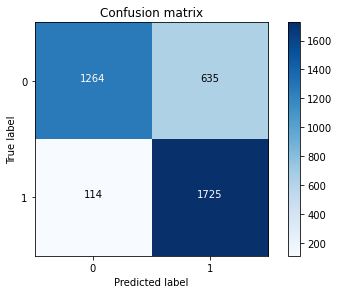

In [6]:
import itertools
def plot_confusion_matrix(cm,
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
 
    # cneter 改为 center
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
class_names = [0, 1]
cnf_matrix = np.array([[1264,635],[114,1725]])
print(type(cnf_matrix))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      title='Confusion matrix')
plt.show()

<Figure size 432x288 with 0 Axes>

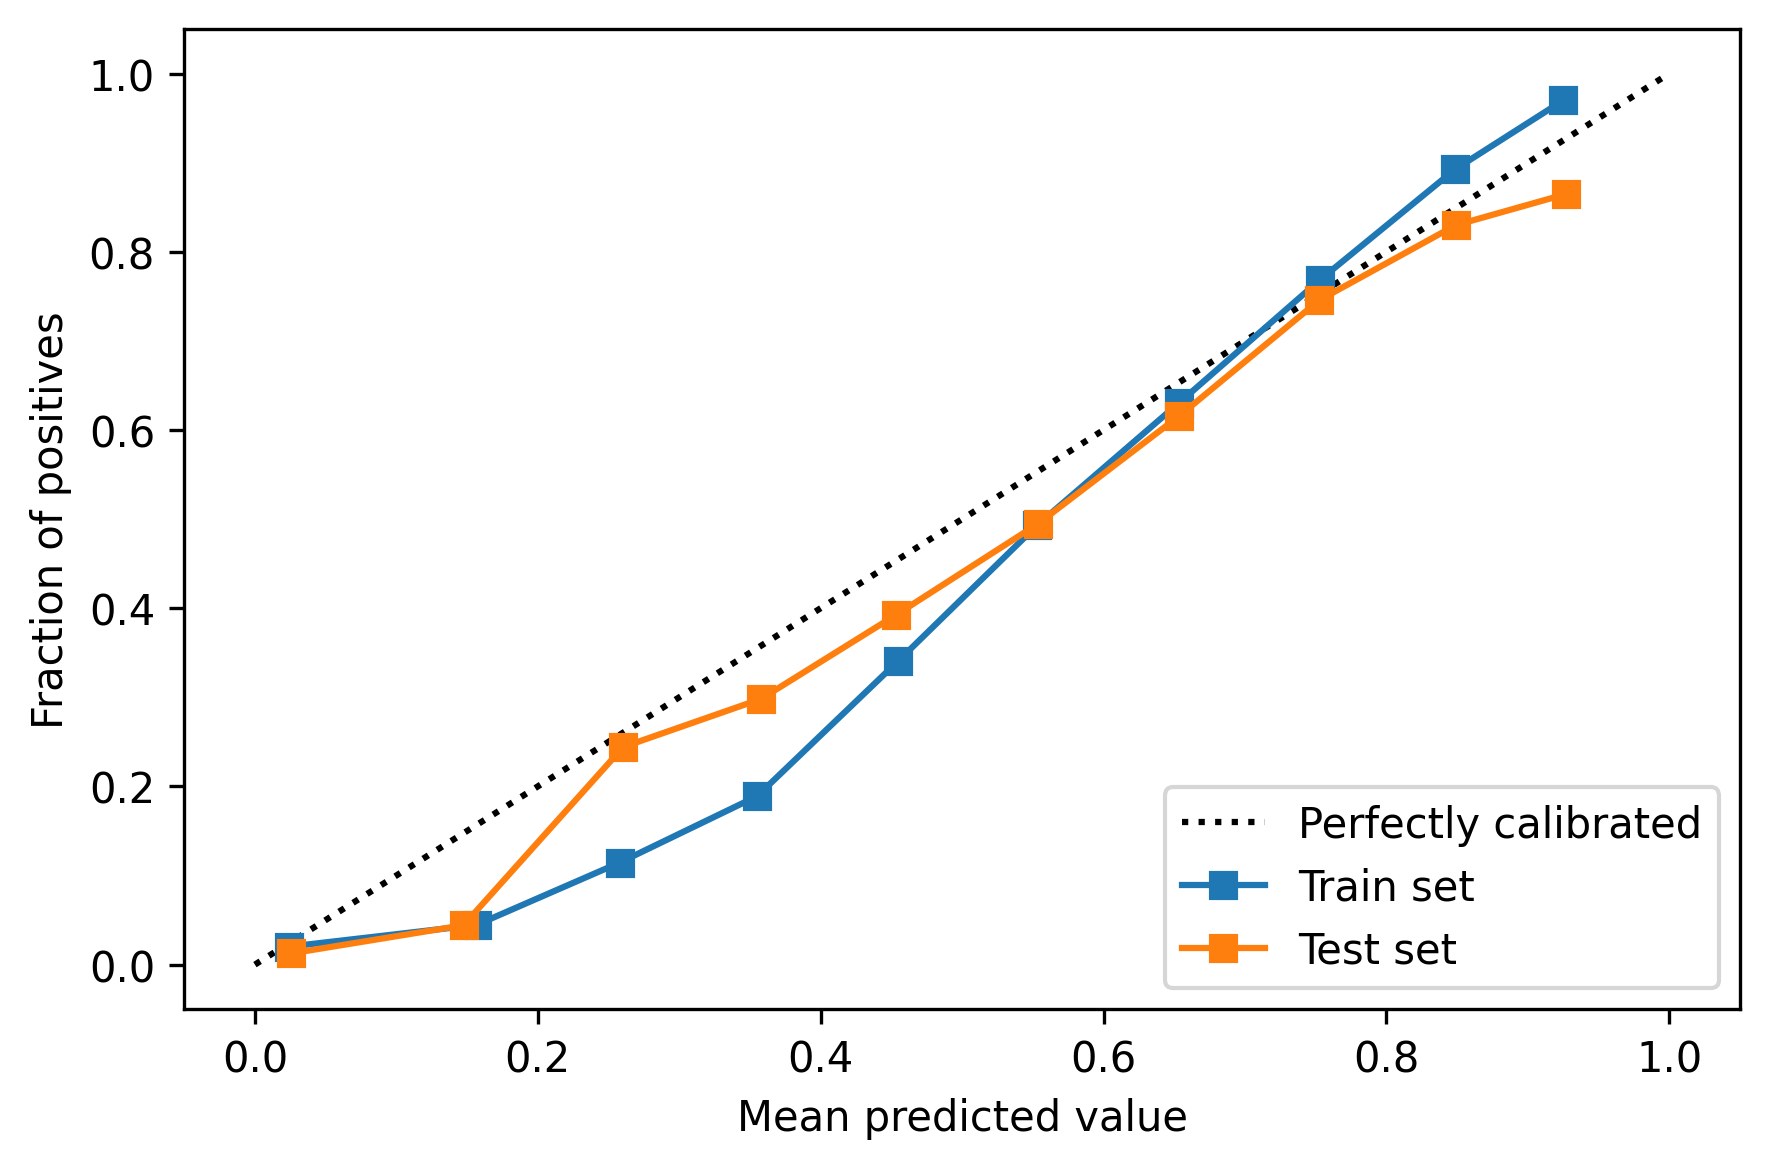

In [7]:
from sklearn.calibration import calibration_curve
def draw_calibration(labels, results,n=5):
    '''
        绘制校准曲线
    :param labels:
    :param results:
    :param n:
    :return:
    '''
    
    plt.figure(0)
    plt.figure(dpi=300)
    plt.title("calibration_curve")
    ax1 = plt.subplot2grid((2, 1), (0, 0), rowspan=2)

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    label = np.array(labels[0])
    result = np.array(results[0])
    result = (result - result.min()) / (result.max() - result.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(label, result, n_bins=n)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % ("Train set",))

    label = np.array(labels[1])
    result = np.array(results[1])
    result = (result - result.min()) / (result.max() - result.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(label, result, n_bins=n)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % ("Test set",))




    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlabel("Mean predicted value")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


draw_calibration([train_y_lists,test_y_lists],[train_pre_lists,test_pre_lists],10)



0.7874414968364004


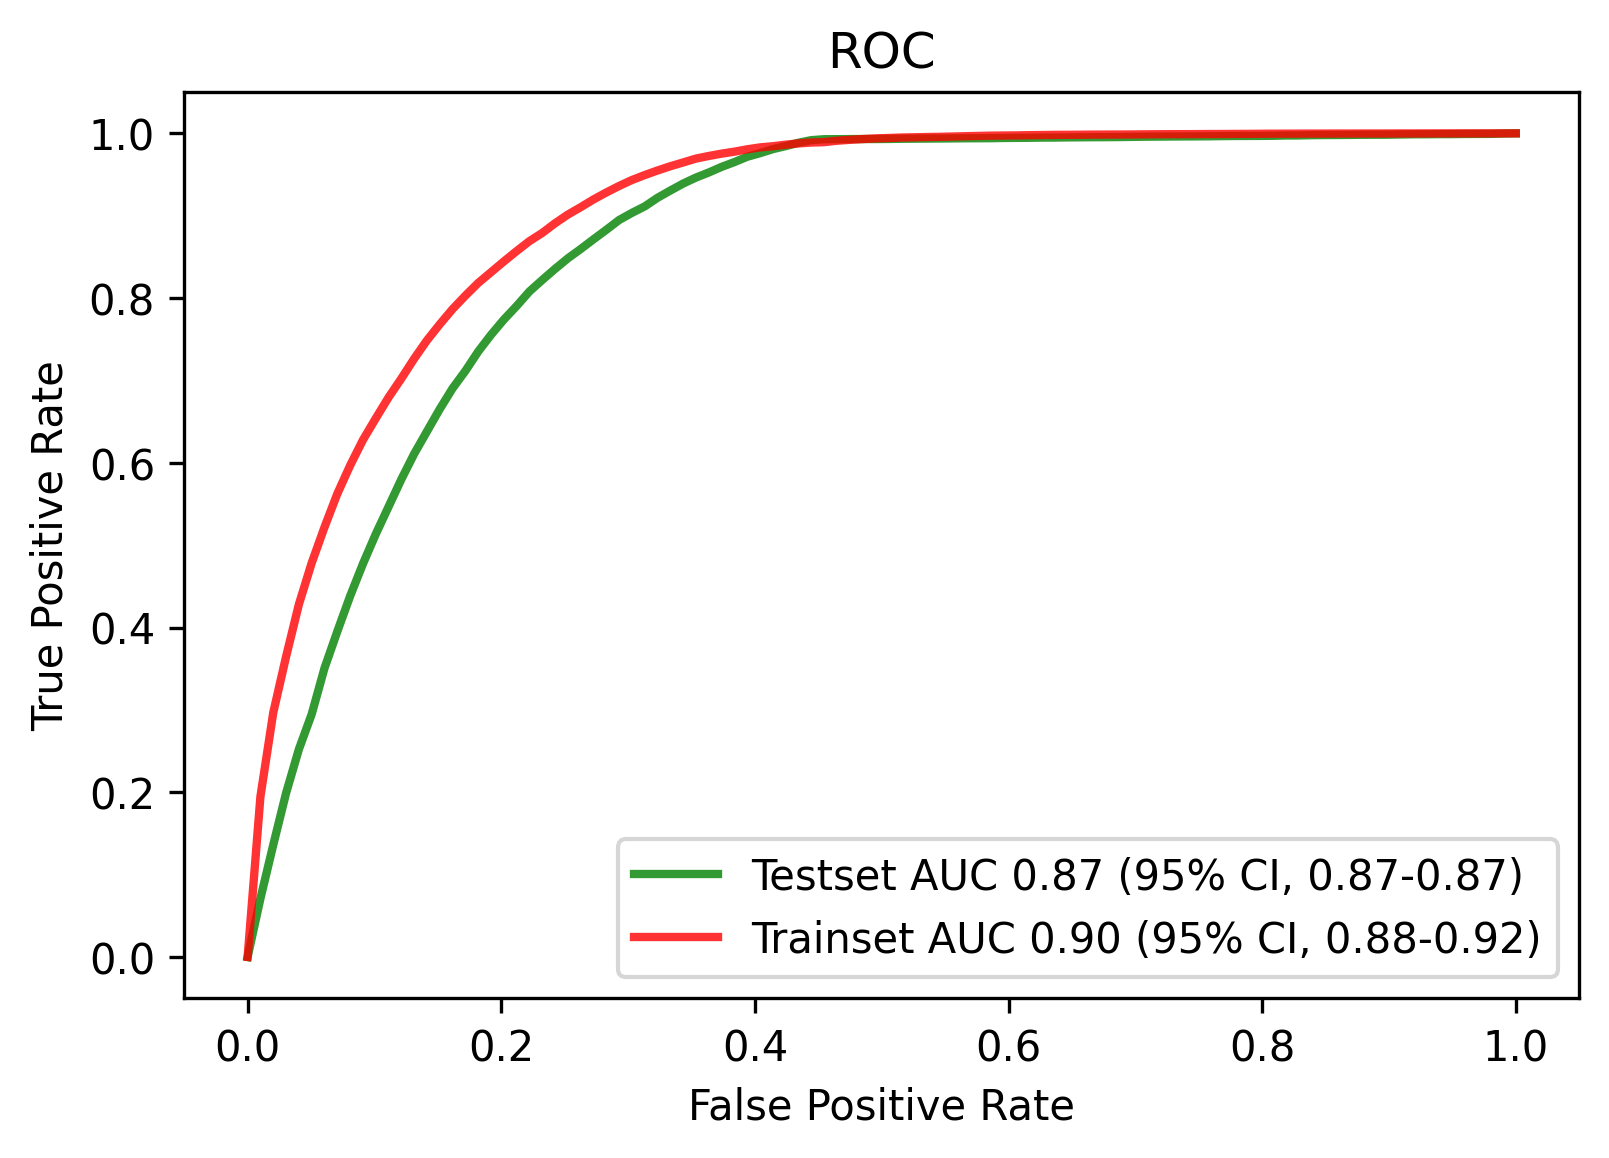

In [8]:
print(np.average(c))
finalpres = pd.DataFrame(bigtestresults)
finaltask = []
lss = []
for i in finalpres.columns:
    temp1 = finalpres.iloc[:, i].value_counts().index[0]
    lss.append(temp1)
mean_test_tpr=np.mean(test_tprs,axis=0)
mean_test_tpr[-1]=1.0
mean_test_auc=auc(mean_fpr,mean_test_tpr)
aucs=[]

for test_tpr in test_tprs:
    auc_=auc(mean_fpr,test_tpr)
    aucs.append(auc_)



'''
    计算置区间
'''
std_test_auc=np.std(aucs,axis=0)

low_=mean_test_auc-1.96*std_test_auc
upper=mean_test_auc+1.96*std_test_auc
plt.figure(dpi=300)
plt.plot(mean_fpr,mean_test_tpr,color='g',label=r'Testset AUC %.2f (95%% CI, %.2f-%.2f)' % (mean_test_auc,low_,upper),lw=2,alpha=0.8)


mean_train_tpr=np.mean(train_tprs,axis=0)
mean_train_tpr[-1]=1.0
mean_train_auc=auc(mean_fpr,mean_train_tpr)
aucs = []
for tpr in train_tprs:
    auc_ = auc(mean_fpr, tpr)
    aucs.append(auc_)

std_train_auc = np.std(aucs, axis=0)
low_=mean_train_auc-1.96*std_train_auc
upper=mean_train_auc+1.96*std_train_auc
plt.plot(mean_fpr,mean_train_tpr,color='r',label='Trainset AUC %.2f (95%% CI, %.2f-%.2f)' % (mean_train_auc,low_,upper),lw=2,alpha=0.8)



#std_train_tpr=np.std(train_tprs,axis=0)
#train_tprs_upper=np.minimum(mean_train_tpr+std_train_tpr,1)
#train_tprs_lower=np.maximum(mean_train_tpr-std_train_tpr,0)
#plt.fill_between(mean_train_tpr,train_tprs_lower,train_tprs_upper,color='b',alpha=.2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()


In [9]:
cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending=False).index[0:15])
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)].sort_values(by='importance',ascending=False)
feature_data= pd.DataFrame(best_features).iloc[:,[0,1]]
feature_data=pd.DataFrame(feature_data.groupby("Feature").mean()['importance'])
feature_data = feature_data.sort_values('importance',ascending= True)

No handles with labels found to put in legend.


<Figure size 2400x1200 with 0 Axes>

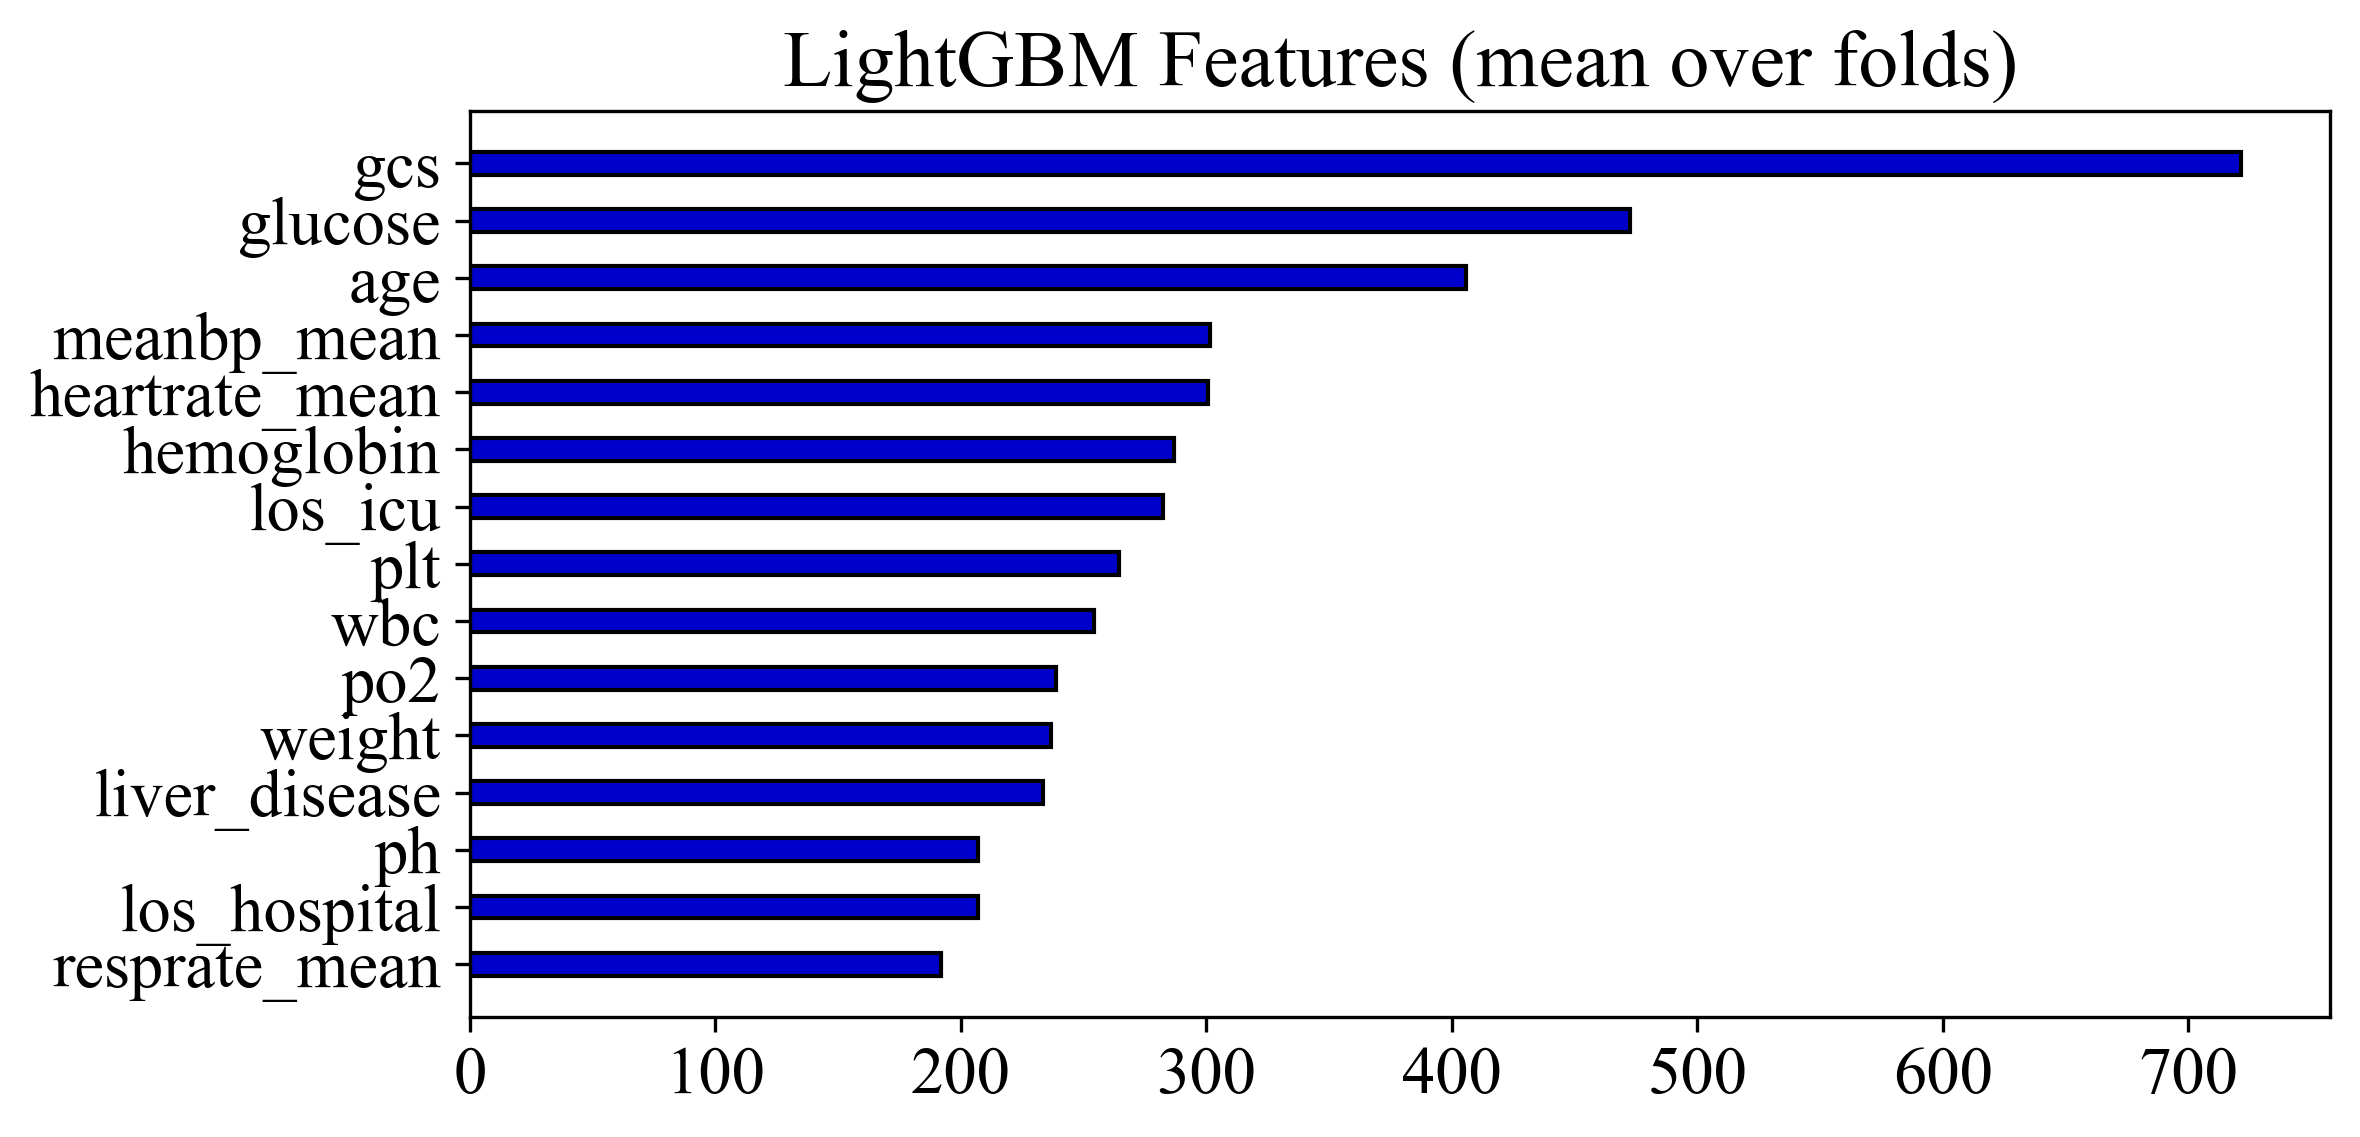

In [10]:
from pylab import mpl
plt.rc('font',family='Times New Roman') 
mpl.rcParams['font.size']=16
plt.figure(figsize=(8,4),dpi=300)#定义画布
#画图
plt.figure(figsize=(8,4),dpi=300)#定义画布
#画横向柱状图
plt.barh(feature_data.index,feature_data['importance'],height=0.4,color='mediumblue',edgecolor='black')
#设置
plt.tick_params(labelsize=16)
# plt.legend(loc=1,framealpha=0)
plt.legend(loc=5,framealpha=0,bbox_to_anchor=(1, 0.1),fontsize=16)
plt.title('LightGBM Features (mean over folds)')
plt.show()